In [3]:
##import our module
from PDE_models import *

import torch
import torch.nn as nn
import torch.nn.functional as F

from neurodiffeq import diff
from neurodiffeq.neurodiffeq import unsafe_diff as unsafe_diff
from neurodiffeq.conditions import IVP, DirichletBVP, DirichletBVP2D, BundleIVP, BundleDirichletBVP
from neurodiffeq.solvers import Solver1D, Solver2D, BundleSolver1D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.generators import Generator1D, Generator2D

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from tqdm.auto import tqdm

In [4]:
##construct a model of 12 heads
k= 16
model = Multihead3(k=k, act = nn.functional.silu, bias=True)
model

Multihead3(
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=768, bias=True)
  (final_layers): ModuleList(
    (0-15): 16 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [5]:
##load the model
import pickle
path = 'experiment_log/16head_model_dec7_trig3_1phase.pickle'
with open(path, 'rb') as f:
  model = pickle.load(f)

In [6]:
model

Multihead3(
  (linear1): Linear(in_features=2, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=256, bias=True)
  (linear3): Linear(in_features=256, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=768, bias=True)
  (final_layers): ModuleList(
    (0-15): 16 x Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
k1 = 2
K2 = np.linspace(1, 2, 8)
A_list = [0.5, -0.5]; b = 0.5; k=16

truth_functions = []; Forcing_functions = []

for k2 in K2:
  for A in A_list:
    truth_functions.append(forcing_decorator_trig(A, k1, k2, b=b))
    Forcing_functions.append(forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0))

#compute the truth solution
truth_solution = [truth_functions[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

# Try Transfer Learning On the 16 Heads Used to Train the model

In [8]:
##define the interior set used to do transfer learning on cpu
x, t, interior_tensor = generate_interior_tensor(I=60, require_grad = False)
##define the boundary set used to do transfer learing on cpu
x_boundary, t_boundary, boundary_tensor = generate_boundary_tensor(B=200, require_grad=False, method='equally-spaced')

In [9]:
##compute all the H matrices
bias=True
H_dict = compute_H_dict(model, I=60, B=200, bias=bias)

Differentiating H w.r.t. x now...
Finished computing Hx.
Differentiating H w.r.t. t now...
Finished computing Ht
Differentiating H_b w.r.t. x now...
Finished computing Hx_b.
Differentiating H_b w.r.t. t now...
Finished computing Ht_b


In [11]:
##save all the Hs in files
import pickle
path = 'experiment_log/16head_H_dict_dec7_trig3_cpu.pickle'
file = open(path, 'wb')
pickle.dump(H_dict, file)
file.close()

In [12]:
##load all the Hs in files
import pickle
path = 'experiment_log/16head_H_dict_dec7_trig3_cpu.pickle'
file = open(path, 'rb')
H_dict = pickle.load(file)
file.close()

In [13]:
##compute the M and Minv matrices
%time
M, Minv = compute_M(H_dict)
print(M.shape)
print("Condition Number: ", np.linalg.cond(M))

CPU times: user 6 µs, sys: 5 µs, total: 11 µs
Wall time: 21.2 µs
(257, 257)
Condition Number:  170028318.52967685


In [14]:
## compute the H matrix evaluated on X_grid for evaluation
_, H  = model(X_grid)
##detach the H
H = H.detach().numpy() #shape (I, 3W)
H = H.reshape(3*H.shape[0], -1) #transform all H into shape (3I, W)
bias = True
if bias: H = np.hstack((H, np.ones((H.shape[0], 1))))

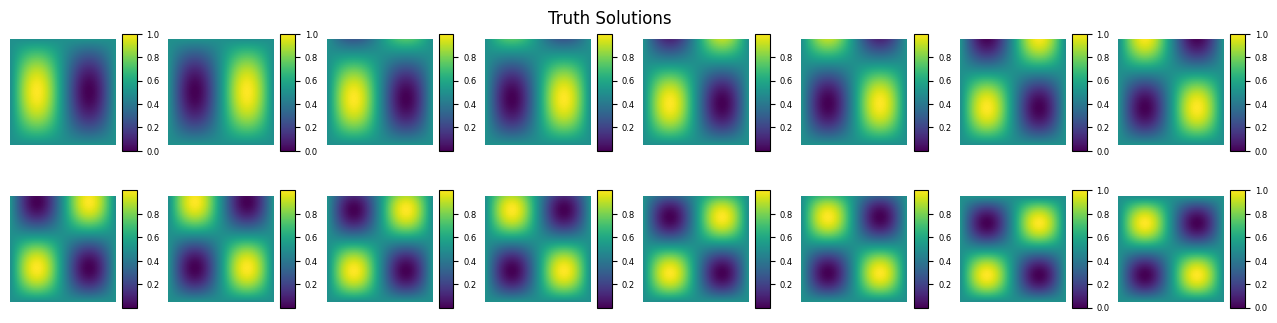

In [15]:
#plot the truth solution
plot_solutions16(truth_solution, "Truth Solutions")

Relative Erorr:  0.015552568466012367
Mean Loss over all Heads:  2.6676576203211443e-05


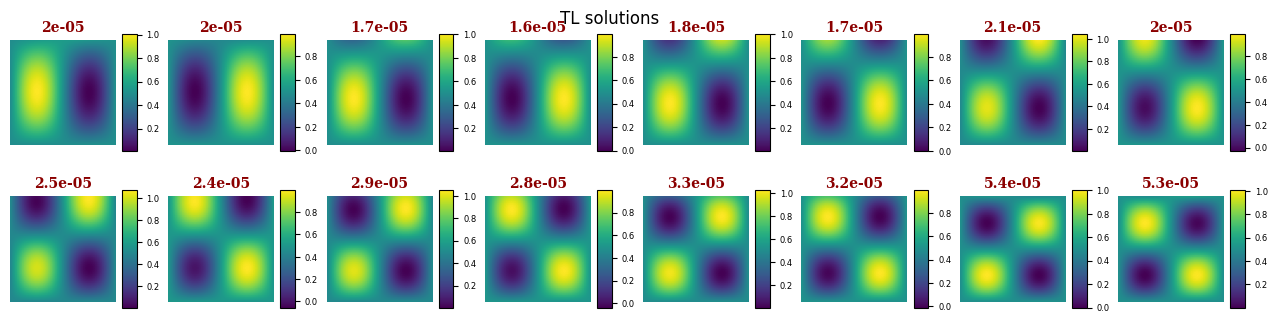

In [16]:
##compute and plot the TL solutions on the 16 heads
Images = []; Poisson_losses = []
for i, force in enumerate(Forcing_functions):
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  image = compute_solution(H, W, I=61)
  Poisson_losses.append(after_loss(H_dict, W, force, b, x, t))
  Images.append(image)
print("Relative Erorr: ", relative_error(Images, truth_solution))
print("Mean Loss over all Heads: ", np.mean(Poisson_losses))

plot_solutions16(Images, "TL solutions", savfig = None, subtitle_list = [round(l, 6) for l in Poisson_losses])

 # Try un-seen parameters

 Fix everything except for K2. k2 had these values when training: [1., 1.14285714, 1.28571429, 1.42857143, 1.57142857, 1.71428571, 1.85714286, 2.]. Let's just take the middle shift.

In [17]:
K2_new = K2 + (K2[1]-K2[0])/2

In [18]:
truth_functions_new = []; Forcing_functions_new = []

for k2 in K2_new:
  for A in A_list:
    truth_functions_new.append(forcing_decorator_trig(A, k1, k2, b=b))
    Forcing_functions_new.append(forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0))

#compute the truth solution
truth_solution_new = [truth_functions_new[i](X_grid[:,0],
                            X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1) for i in range(k)]

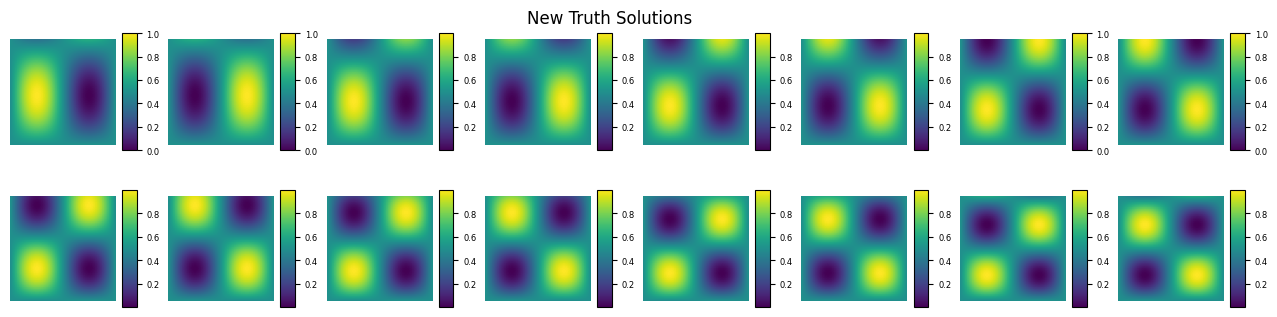

In [19]:
#plot the new truth solution
plot_solutions16(truth_solution_new, "New Truth Solutions")

Relative Erorr:  0.015867490020797417
Mean Loss over all Heads:  3.254916217664729e-05


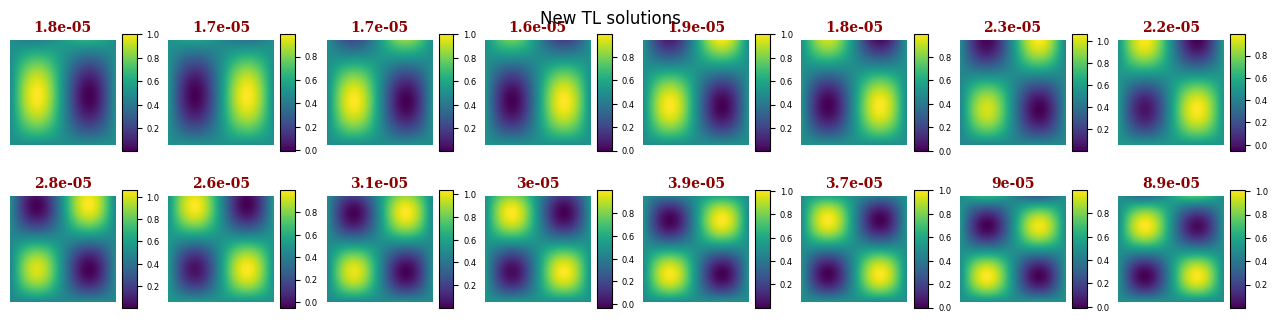

In [20]:
##compute and plot the TL solutions on the 16 heads
Images_new = []; Poisson_losses_new = []
for i, force in enumerate(Forcing_functions_new):
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  image = compute_solution(H, W, I=61)
  Poisson_losses_new.append(after_loss(H_dict, W, force, b, x, t))
  Images_new.append(image)
print("Relative Erorr: ", relative_error(Images_new, truth_solution_new))
print("Mean Loss over all Heads: ", np.mean(Poisson_losses_new))

plot_solutions16(Images_new, "New TL solutions", savfig = None, subtitle_list = [round(l, 6) for l in Poisson_losses_new])

In [21]:
##vary only k2 to see how the loss varies
K2_list = np.linspace(1, 2, 100)
PoissonLoss_over_k2 = []; A = 0.5
for k2 in tqdm(K2_list):
  #build the forcing function
  force = forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_k2.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/100 [00:00<?, ?it/s]

In [22]:
# vary only b to see how the loss changes
b_list = np.linspace(-1, 1, 200); A = 0.5; k1 = 2; k2 = 1.2

PoissonLoss_over_b = [];
for b in tqdm(b_list):
  #build the forcing function
  force = forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_b.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/200 [00:00<?, ?it/s]

In [23]:
# only vary A to see how the loss goes
k1 = 2; k2 = 1.2; b = 0.5
A_list_new = np.linspace(-1, 1, 100)

PoissonLoss_over_A = [];
for A in tqdm(A_list_new):
  #build the forcing function
  force = forcing_decorator_trig(-A*np.pi**2*(k1**2 + k2**2), k1, k2, b=0)
  #compute the TL W
  W = compute_TLW(b, force, Minv, H_dict, x, t)
  PoissonLoss_over_A.append(after_loss(H_dict, W, force, b, x, t))

  0%|          | 0/100 [00:00<?, ?it/s]

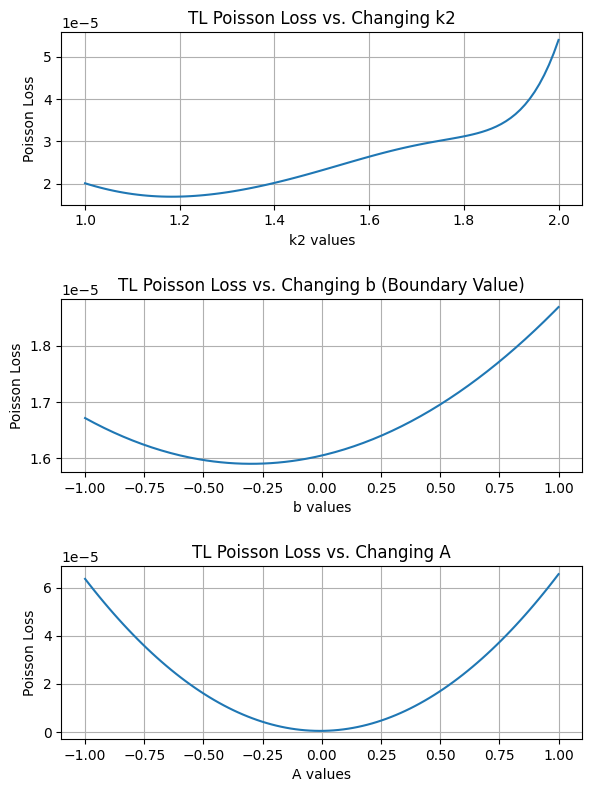

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(6, 8))
ax[0].plot(K2_list, PoissonLoss_over_k2)
ax[0].set_xlabel("k2 values");
ax[0].set_ylabel("Poisson Loss");
ax[0].set_title("TL Poisson Loss vs. Changing k2");
ax[0].grid();
ax[1].plot(b_list, PoissonLoss_over_b)
ax[1].set_xlabel("b values");
ax[1].set_ylabel("Poisson Loss");
ax[1].set_title("TL Poisson Loss vs. Changing b (Boundary Value)");
ax[1].grid();
ax[2].plot(A_list_new, PoissonLoss_over_A)
ax[2].set_xlabel("A values");
ax[2].set_ylabel("Poisson Loss");
ax[2].set_title("TL Poisson Loss vs. Changing A");
ax[2].grid();
fig.tight_layout(pad=1.0)

# Try KG Equations

Then I used the model trained by these trigonometric functions to do solve KG equations using one-shot TL and perturbation method. The KG equations have forcing function of form f(x, t) = 2At and constant boundary conditions. I solved 24 such KG equations and the results are suprisingly good. Over the 24 KG equations, we get a relative error of 0.0036 and MSE 3.8e-5. (These values are computed by comparing to the numerical solutions obtained by Wolfram Mathematica). We also get the following KG loss scores: Mean KG total Loss:  0.008418335787116883
Mean KG PDE residual:  0.008415399015115217
Mean KG BC Loss:  2.936772001665193e-06





In [25]:
p = 20
landa = 0.5;

result_list = []

A_list = [-2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2];
B_test_list = [0.5, 1, 1.5]; test_forcing_functions = []
for A in A_list:
  for b in B_test_list:
    f = forcing_decorator(A)
    test_forcing_functions.append(f)
    f0_values = f(x, t).detach().numpy()
    result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
    result_list.append(result)

Function finisheds in 0.115122 seconds. On average, each PDE is solved using 0.005482 seconds
Function finisheds in 0.077054 seconds. On average, each PDE is solved using 0.003669 seconds
Function finisheds in 0.079497 seconds. On average, each PDE is solved using 0.003786 seconds
Function finisheds in 0.080852 seconds. On average, each PDE is solved using 0.00385 seconds
Function finisheds in 0.083649 seconds. On average, each PDE is solved using 0.003983 seconds
Function finisheds in 0.085783 seconds. On average, each PDE is solved using 0.004085 seconds
Function finisheds in 0.105551 seconds. On average, each PDE is solved using 0.005026 seconds
Function finisheds in 0.080927 seconds. On average, each PDE is solved using 0.003854 seconds
Function finisheds in 0.078468 seconds. On average, each PDE is solved using 0.003737 seconds
Function finisheds in 0.088084 seconds. On average, each PDE is solved using 0.004194 seconds
Function finisheds in 0.078171 seconds. On average, each PDE 

In [26]:
##let's compute these TL solution's KG loss
KG_loss_list = []
counter = 0
for A in tqdm(A_list):
  for b0 in B_test_list:
    KG_loss_list.append(KG_loss(model, result_list[counter]['W'], landa, forcing_decorator(A), b0=b0))
    counter+=1

  0%|          | 0/8 [00:00<?, ?it/s]

Mean KG total Loss:  0.008431172744687332
Mean KG PDE residual:  0.008428379354784195
Mean KG BC Loss:  2.793389903136279e-06


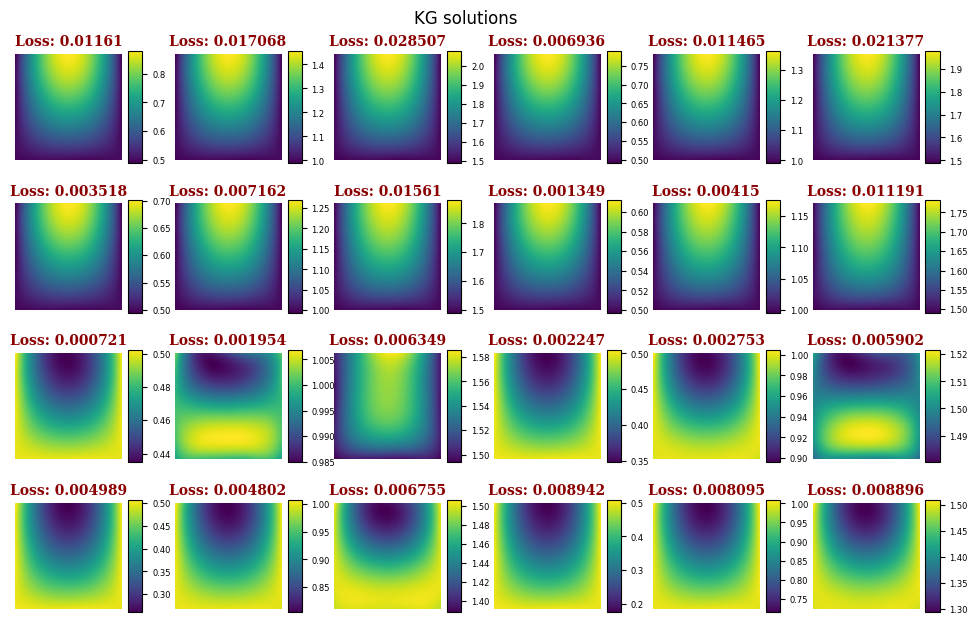

In [27]:
subtitle_list = ["Loss: {}".format(round(result['total_loss'], 6)) for result in KG_loss_list]
sol_list = [result['sol'] for result in result_list]
plot_solutions24(sol_list, 'KG solutions', savfig = None, figsize=(12, 7), subtitle_list=subtitle_list)
print("Mean KG total Loss: ", np.mean([dic['total_loss'] for dic in KG_loss_list]))
print("Mean KG PDE residual: ", np.mean([dic['pde_loss'] for dic in KG_loss_list]))
print("Mean KG BC Loss: ", np.mean([dic['bc_loss'] for dic in KG_loss_list]))

### Try to see how the KG loss changes over different p




In [29]:
KG_loss_p = []
for p in tqdm(range(2, 13)):
  landa = 0.5;

  result_list = []; KG_loss_list = []

  A_list = [-2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2];
  B_test_list = [0.5, 1, 1.5];
  for A in A_list:
    for b in B_test_list:
      f = forcing_decorator(A)
      f0_values = f(x, t).detach().numpy()
      result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
      result_list.append(result)
      KG_loss_list.append(KG_loss(model, result['W'], landa, forcing_decorator(A), b0=b)['total_loss'])
  KG_loss_p.append(np.mean(KG_loss_list))


  0%|          | 0/11 [00:00<?, ?it/s]

Function finisheds in 0.029575 seconds. On average, each PDE is solved using 0.009858 seconds
Function finisheds in 0.010106 seconds. On average, each PDE is solved using 0.003369 seconds
Function finisheds in 0.013933 seconds. On average, each PDE is solved using 0.004644 seconds
Function finisheds in 0.009904 seconds. On average, each PDE is solved using 0.003301 seconds
Function finisheds in 0.008893 seconds. On average, each PDE is solved using 0.002964 seconds
Function finisheds in 0.011058 seconds. On average, each PDE is solved using 0.003686 seconds
Function finisheds in 0.026507 seconds. On average, each PDE is solved using 0.008836 seconds
Function finisheds in 0.009117 seconds. On average, each PDE is solved using 0.003039 seconds
Function finisheds in 0.008787 seconds. On average, each PDE is solved using 0.002929 seconds
Function finisheds in 0.010469 seconds. On average, each PDE is solved using 0.00349 seconds
Function finisheds in 0.008169 seconds. On average, each PDE 

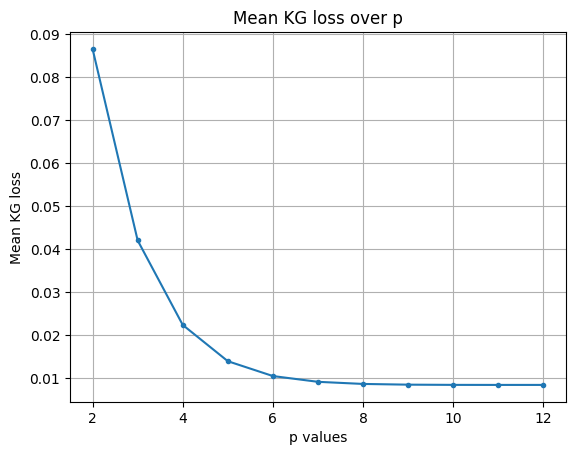

In [30]:
plt.plot(range(2, 13), KG_loss_p, '.-', label='KG loss');
plt.xlabel('p values');
plt.ylabel('Mean KG loss');
plt.title("Mean KG loss over p");
plt.grid();

# Try Another Set of KG equations with difference forcing functions


In [31]:
p = 21
landa = 0.5; b =0.5

result_list2 = []

for force in Forcing_functions:
  f0_values = force(x, t).detach().numpy()
  result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
  result_list2.append(result)

Function finisheds in 0.118303 seconds. On average, each PDE is solved using 0.005377 seconds
Function finisheds in 0.109619 seconds. On average, each PDE is solved using 0.004983 seconds
Function finisheds in 0.112731 seconds. On average, each PDE is solved using 0.005124 seconds
Function finisheds in 0.116947 seconds. On average, each PDE is solved using 0.005316 seconds
Function finisheds in 0.114942 seconds. On average, each PDE is solved using 0.005225 seconds
Function finisheds in 0.096454 seconds. On average, each PDE is solved using 0.004384 seconds
Function finisheds in 0.108751 seconds. On average, each PDE is solved using 0.004943 seconds
Function finisheds in 0.10443 seconds. On average, each PDE is solved using 0.004747 seconds
Function finisheds in 0.094185 seconds. On average, each PDE is solved using 0.004281 seconds
Function finisheds in 0.078218 seconds. On average, each PDE is solved using 0.003555 seconds
Function finisheds in 0.090076 seconds. On average, each PDE 

In [32]:
##let's compute these TL solution's KG loss
KG_loss_list2 = []
counter = 0; b0=0.5

for force in tqdm(Forcing_functions):
  KG_loss_list2.append(KG_loss(model, result_list2[counter]['W'], landa, force, b0=b0))
  counter+=1

  0%|          | 0/16 [00:00<?, ?it/s]

Mean KG total Loss:  0.008775491022087741
Mean KG PDE residual:  0.008771819903097893
Mean KG BC Loss:  3.671118989848078e-06


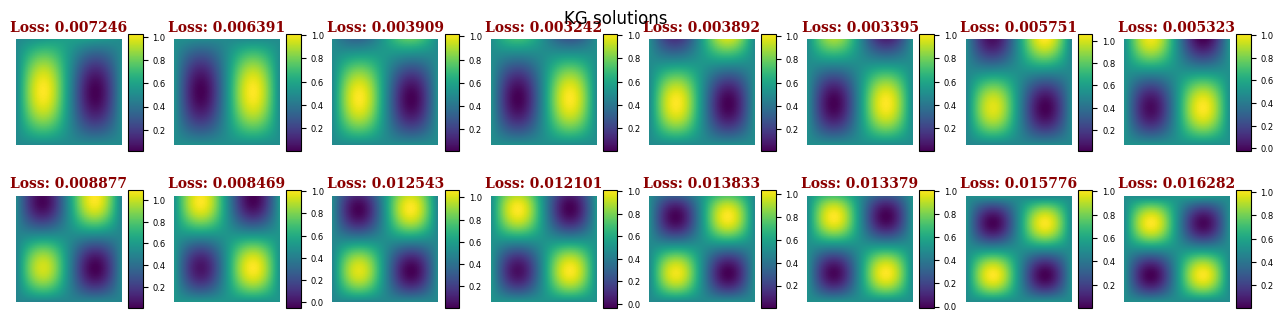

In [33]:
subtitle_list2 = ["Loss: {}".format(round(result['total_loss'], 6)) for result in KG_loss_list2]
sol_list2 = [result['sol'] for result in result_list2]
plot_solutions16(sol_list2, 'KG solutions', savfig = None, subtitle_list=subtitle_list2)
print("Mean KG total Loss: ", np.mean([dic['total_loss'] for dic in KG_loss_list2]))
print("Mean KG PDE residual: ", np.mean([dic['pde_loss'] for dic in KG_loss_list2]))
print("Mean KG BC Loss: ", np.mean([dic['bc_loss'] for dic in KG_loss_list2]))

Try the following truth function:

$$u(x, t) = Asin(k_1 \pi x)t^2 + b$$

For KG PDE, the corresponding forcing function would be:

$$f(x, t) = Asin(k_1 \pi x)(2 - k_1^2 \pi^2 t^2) + \lambda u^2$$

In [34]:
def new_truth_decorator(A, k1, b):
  def func(x, t):
    return A*torch.sin(k1*torch.pi*x)*(t**2) + b
  return func

def new_forcing_decorator(A, k1, landa, b):
  def force(x, t):
    u_func = new_truth_decorator(A, k1, b)
    u = u_func(x, t)
    result = A*torch.sin(k1*torch.pi*x)*(2 - (k1**2)*(torch.pi**2)*(t**2)) + landa*(u**2)
    return result
  return force

In [35]:
result_list = []
truth_list = []
KG_loss_list3 = []

landa=0.2; p=12
K1_list = [1, 2, 3, 4]
A_list = [0.5, -0.5]
b_list = [0.5, 1]
for k1 in K1_list:
  for A in A_list:
    for b in b_list:
      force = new_forcing_decorator(A, k1, landa=landa, b=b)
      f0_values = force(x, t).detach().numpy()
      result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
      result_list.append(result)
      truth = new_truth_decorator(A, k1, b)(X_grid[:,0], X_grid[:,1]).cpu().detach().numpy().reshape(round(X_grid.shape[0]**.5), -1)
      truth_list.append(truth)
      KG_loss_list3.append(KG_loss(model, result['W'], landa, force, b0=b))

Function finisheds in 0.090265 seconds. On average, each PDE is solved using 0.006943 seconds
Function finisheds in 0.063057 seconds. On average, each PDE is solved using 0.004851 seconds
Function finisheds in 0.064202 seconds. On average, each PDE is solved using 0.004939 seconds
Function finisheds in 0.06148 seconds. On average, each PDE is solved using 0.004729 seconds
Function finisheds in 0.068004 seconds. On average, each PDE is solved using 0.005231 seconds
Function finisheds in 0.052511 seconds. On average, each PDE is solved using 0.004039 seconds
Function finisheds in 0.093554 seconds. On average, each PDE is solved using 0.007196 seconds
Function finisheds in 0.044548 seconds. On average, each PDE is solved using 0.003427 seconds
Function finisheds in 0.042925 seconds. On average, each PDE is solved using 0.003302 seconds
Function finisheds in 0.066936 seconds. On average, each PDE is solved using 0.005149 seconds
Function finisheds in 0.048271 seconds. On average, each PDE 

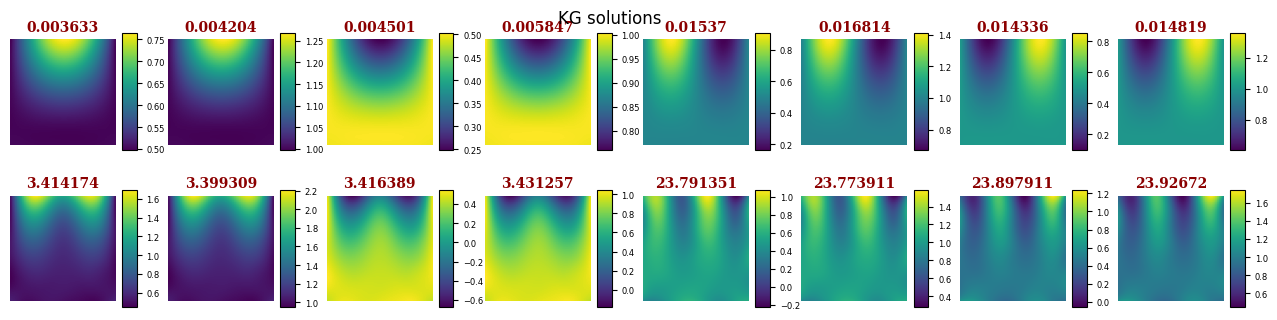

In [36]:
plot_solutions16([result['sol'] for result in result_list], 'KG solutions',
                 subtitle_list = [round(loss['total_loss'], 6) for loss in KG_loss_list3])

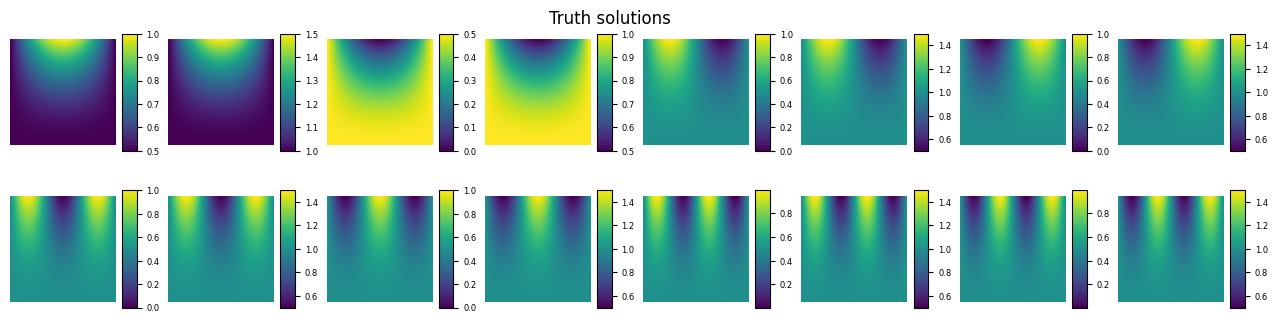

In [37]:
plot_solutions16(truth_list, 'Truth solutions', savfig = None)

In [38]:
relative_error([result['sol'] for result in result_list], truth_list)

0.10183303886844843

In [48]:
def new_forcing_decorator(A, k1, k2, landa, b):
  def force(x, t):
    laplace = -A*torch.pi**2*(k1**2 + k2**2)*torch.sin(k1*torch.pi*x)*torch.sin(k2*torch.pi*t)
    landa_term = landa*(A*torch.sin(k1*torch.pi*x)*torch.sin(k2*torch.pi*t)+b)**2
    return laplace + landa_term
  return force

In [49]:
k1 = 2
K2 = np.linspace(1, 2, 8)
A_list = [0.5, -0.5]; b = 0.5;

result_list = []; KG_loss_list4 = []
landa = 0.5; p = 12

for k2 in K2:
  for A in A_list:
    force = new_forcing_decorator(A, k1, k2, landa, b)
    f0_values = force(x, t).detach().numpy()
    result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
    result_list.append(result)
    KG_loss_list4.append(KG_loss(model, result['W'], landa, force, b0=b))

Function finisheds in 0.084057 seconds. On average, each PDE is solved using 0.006466 seconds
Function finisheds in 0.06075 seconds. On average, each PDE is solved using 0.004673 seconds
Function finisheds in 0.066433 seconds. On average, each PDE is solved using 0.00511 seconds
Function finisheds in 0.054107 seconds. On average, each PDE is solved using 0.004162 seconds
Function finisheds in 0.052638 seconds. On average, each PDE is solved using 0.004049 seconds
Function finisheds in 0.049804 seconds. On average, each PDE is solved using 0.003831 seconds
Function finisheds in 0.051481 seconds. On average, each PDE is solved using 0.00396 seconds
Function finisheds in 0.052055 seconds. On average, each PDE is solved using 0.004004 seconds
Function finisheds in 0.102044 seconds. On average, each PDE is solved using 0.00785 seconds
Function finisheds in 0.080908 seconds. On average, each PDE is solved using 0.006224 seconds
Function finisheds in 0.046162 seconds. On average, each PDE is 

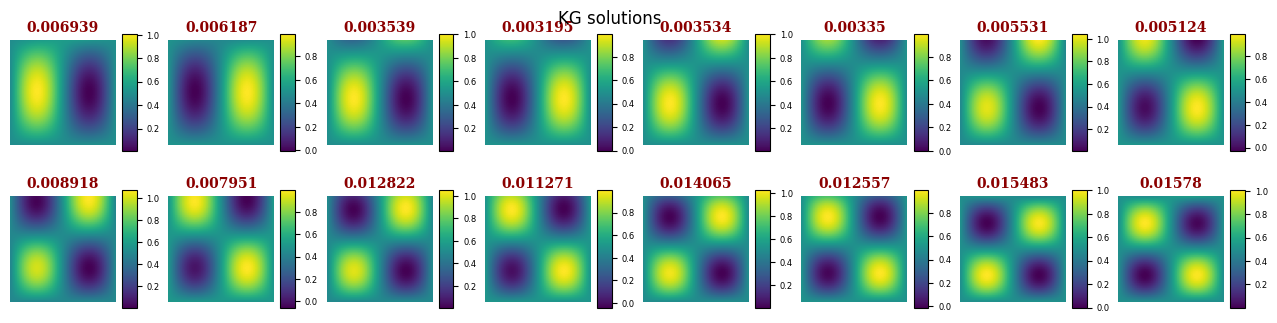

In [50]:
plot_solutions16([result['sol'] for result in result_list], 'KG solutions',
                 subtitle_list = [round(loss['total_loss'], 6) for loss in KG_loss_list4])

In [43]:
relative_error([result['sol'] for result in result_list], truth_solution)

0.01637075112905549

Try zero forcing function

In [51]:
p = 12
result_list = []; KG_loss_list5 = []
for landa in [0.4, 0.5, 0.6, 0.7]:
  for b in [0.2, 0.4, 0.6, 0.8]:
    force = lambda x, t: torch.zeros((3600, 1))
    f0_values = torch.zeros((3600, 1))
    result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
    result_list.append(result)
    KG_loss_list5.append(KG_loss(model, result['W'], landa, force, b0=b))

Function finisheds in 0.102951 seconds. On average, each PDE is solved using 0.007919 seconds
Function finisheds in 0.068837 seconds. On average, each PDE is solved using 0.005295 seconds
Function finisheds in 0.153215 seconds. On average, each PDE is solved using 0.011786 seconds
Function finisheds in 0.052981 seconds. On average, each PDE is solved using 0.004075 seconds
Function finisheds in 0.054457 seconds. On average, each PDE is solved using 0.004189 seconds
Function finisheds in 0.056355 seconds. On average, each PDE is solved using 0.004335 seconds
Function finisheds in 0.048421 seconds. On average, each PDE is solved using 0.003725 seconds
Function finisheds in 0.067578 seconds. On average, each PDE is solved using 0.005198 seconds
Function finisheds in 0.062575 seconds. On average, each PDE is solved using 0.004813 seconds
Function finisheds in 0.059368 seconds. On average, each PDE is solved using 0.004567 seconds
Function finisheds in 0.051407 seconds. On average, each PDE

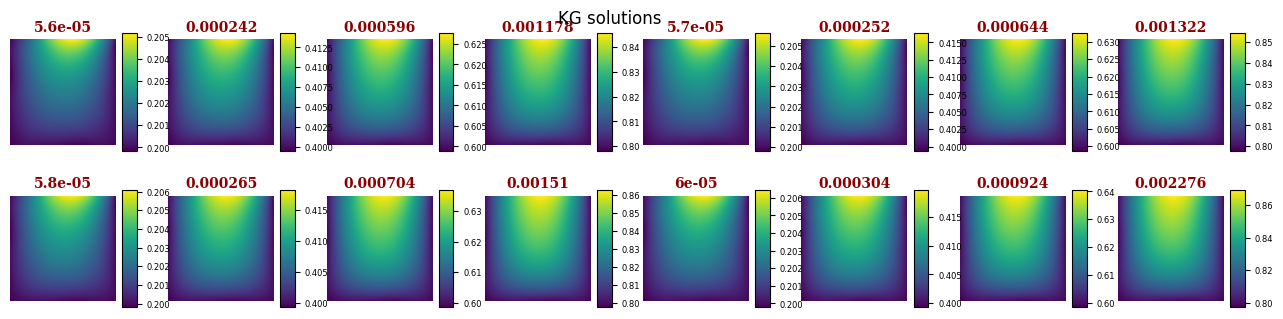

In [52]:
plot_solutions16([result['sol'] for result in result_list], 'KG solutions',
                 subtitle_list = [round(loss['total_loss'], 6) for loss in KG_loss_list5])

## Manufactured solution 
Let's fix 
$$
u(x, t) = Ax(x-1)sin(kt) + b
$$

The corresponding forcig function should be

$$
f(x, t) = Asin(kt)(2-k^2 x(x-1)) + \lambda u^2
$$

In [53]:
def function_decorator3(A, k, b=0):
    def func(x, t):
        return A*x*(x-1)*torch.sin(k*t) + b
    return func

def forcing_decorator3(A, k, landa, b=0):
    func = function_decorator3(A, k, b)
    def force(x, t):
        u = func(x, t)
        return A*torch.sin(k*t)*(2-(k**2)*x*(x-1)) + landa*u**2
    return force

Let's just see an example of what the exact solution and its corresponding forcing function look like.

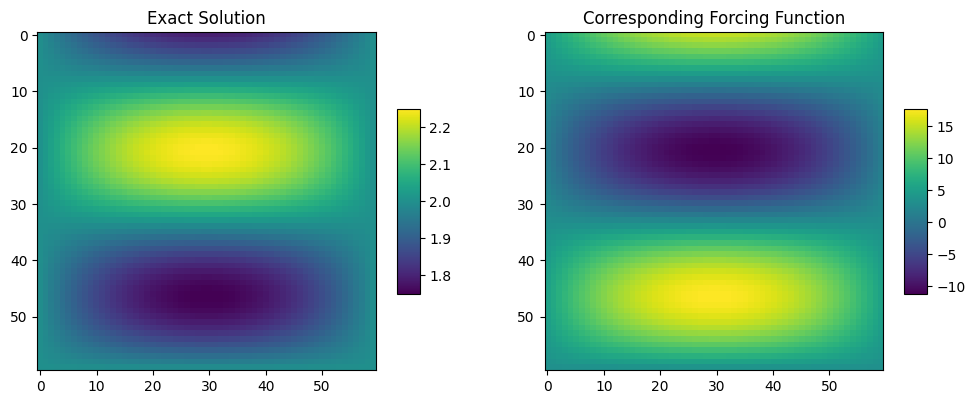

In [54]:
A = 1; k =2*np.pi + 1; landa = .8
exact_func = function_decorator3(A, k, b=2)
forcing = forcing_decorator3(A, k, landa, b=2)
exact_values = exact_func(x,t).detach().numpy().reshape(60, -1)
forcing_values = forcing(x, t).detach().numpy().reshape(60, -1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6));
im0 = ax[0].imshow((exact_values.T)[::-1]);
im1 = ax[1].imshow((forcing_values.T)[::-1]);
cbar0 = fig.colorbar(im0, ax=ax[0], shrink=0.4, aspect=8);
cbar0.ax.tick_params(labelsize=10);
cbar1 = fig.colorbar(im1, ax=ax[1], shrink=0.4, aspect=8);
cbar1.ax.tick_params(labelsize=10);
ax[0].set_title("Exact Solution");
ax[1].set_title("Corresponding Forcing Function");

In [55]:
A_list = [-1, 1]; K_list = np.linspace(np.pi, 2*np.pi, 8);
manufactured_list = []
perturbation_list = []
KG_loss_list = []
mse_list = []
landa = 0.8; b = 2; p = 20

for A in A_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator3(A, k, landa=landa, b=b)
        f0_values = force(x, t).detach().numpy()
        result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator3(A, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the KG loss
        KG_loss_list.append(KG_loss(model, result['W'], landa, force, b0=b))
        

Function finisheds in 0.118027 seconds. On average, each PDE is solved using 0.00562 seconds
Function finisheds in 0.115254 seconds. On average, each PDE is solved using 0.005488 seconds
Function finisheds in 0.124407 seconds. On average, each PDE is solved using 0.005924 seconds
Function finisheds in 0.094821 seconds. On average, each PDE is solved using 0.004515 seconds
Function finisheds in 0.10925 seconds. On average, each PDE is solved using 0.005202 seconds
Function finisheds in 0.095109 seconds. On average, each PDE is solved using 0.004529 seconds
Function finisheds in 0.09921 seconds. On average, each PDE is solved using 0.004724 seconds
Function finisheds in 0.099424 seconds. On average, each PDE is solved using 0.004734 seconds
Function finisheds in 0.138989 seconds. On average, each PDE is solved using 0.006619 seconds
Function finisheds in 0.075663 seconds. On average, each PDE is solved using 0.003603 seconds
Function finisheds in 0.108017 seconds. On average, each PDE is

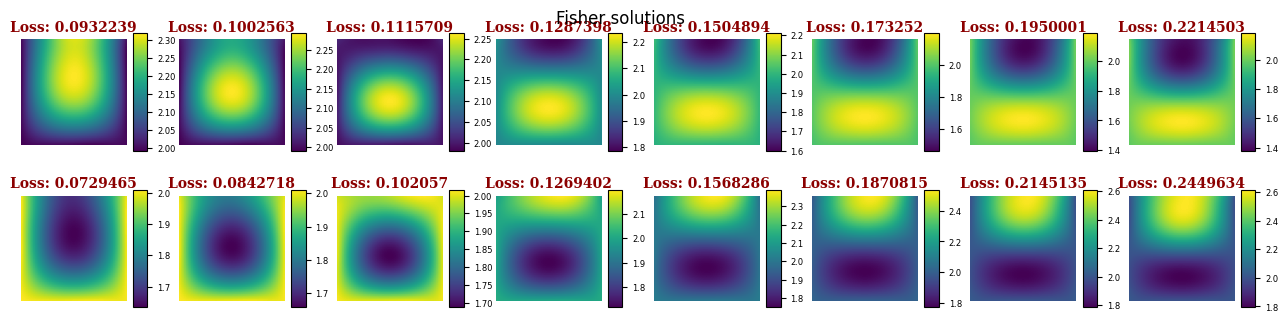

In [56]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in KG_loss_list]);

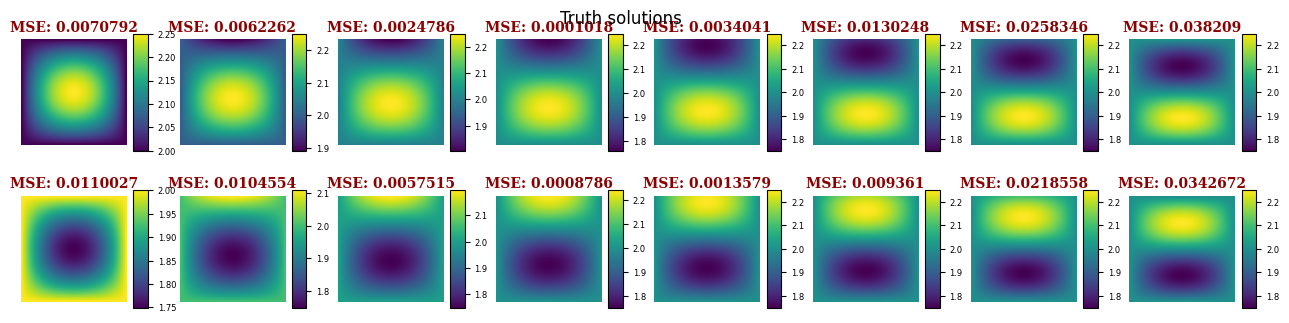

In [57]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [60]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in KG_loss_list]))
#print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in KG_loss_list]))
#print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in KG_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)
print("Mean MSE: ", np.mean(mse_list))

Average Fisher's Loss:  0.14772407168149865
Mean relative error:  0.032959828588267556
Mean MSE:  0.011955540724599704


In [61]:
indices = [0, 2, 4, 6, 8, 10, 12, 14]
TL_solution = np.array(perturbation_list)[indices]
truth_solution = np.array(manufactured_list)[indices]
import matplotlib.cm as cm
from matplotlib.colors import Normalize

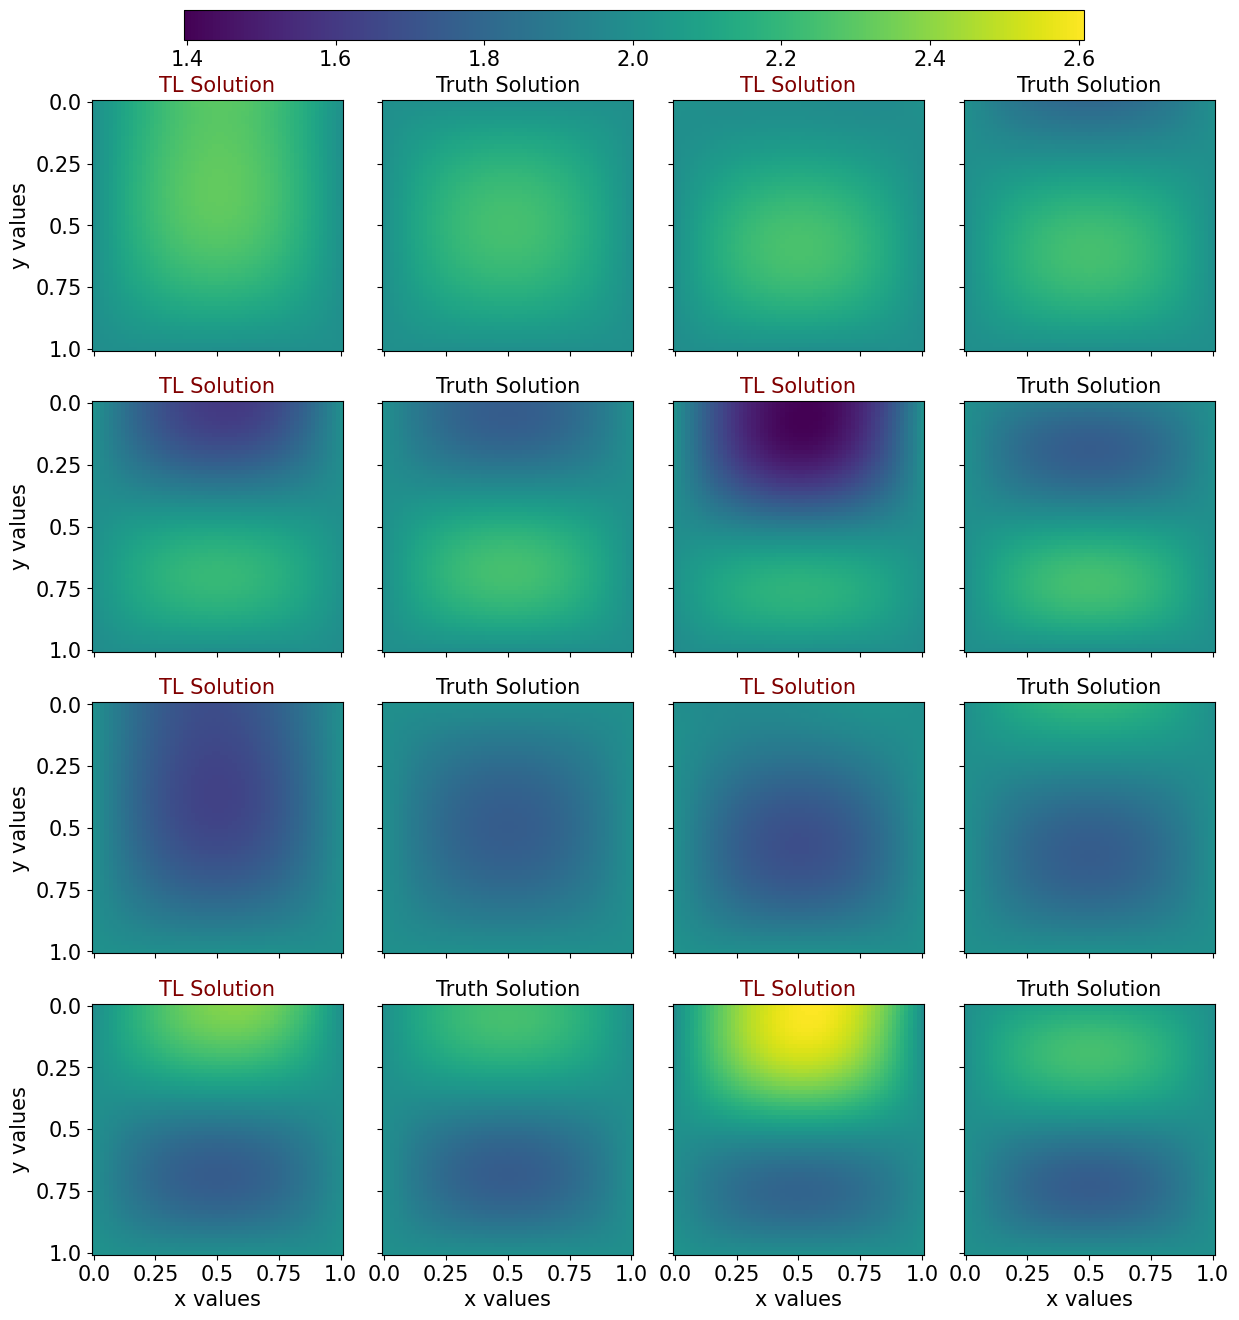

In [62]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex = True, sharey=True);
# Create color map
cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min(min([result.min() for result in TL_solution]), min([result.min() for result in truth_solution]))
global_max = max(max([result.max() for result in TL_solution]), max([result.max() for result in truth_solution]))
normalizer = Normalize(global_min, global_max)
im = cm.ScalarMappable(norm=normalizer)

for i, tl in enumerate(TL_solution):
    j = i//2; k = 2*(i%2)
    ax[j][k].imshow(tl[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("TL Solution", fontsize=15, color='maroon');
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
for i, truth in enumerate(truth_solution):
    j = i//2; k = 2*(i%2)+1
    ax[j][k].imshow(truth[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("Truth Solution", fontsize=15);
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)

# Create a color bar axis
cax = fig.add_axes([0.2, 0.92, 0.6, 0.02])  # [left, bottom, width, height]
# Create the color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.0)

for i in range(4):
    ax[3][i].set_xlabel('x values', fontsize=15)
    ax[i][0].set_ylabel('y values', fontsize=15)

#plt.savefig('KG_result.png',dpi=500, bbox_inches='tight')

Change the range of k to $[2\pi, 3\pi]$

In [82]:
A_list = [1, 2]; K_list = np.linspace(2*np.pi, 3*np.pi, 8);
manufactured_list = []
perturbation_list = []
KG_loss_list = []
mse_list = []
landa = 0.5; b = 0.5; p = 12

for A in A_list:
    for k in K_list:
        ##compute the Perturbation solutions
        force = forcing_decorator3(A, k, landa=landa, b=b)
        f0_values = force(x, t).detach().numpy()
        result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator3(A, k, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the KG loss
        KG_loss_list.append(KG_loss(model, result['W'], landa, force, b0=b))
        

Function finisheds in 0.078799 seconds. On average, each PDE is solved using 0.006061 seconds
Function finisheds in 0.05507 seconds. On average, each PDE is solved using 0.004236 seconds
Function finisheds in 0.056222 seconds. On average, each PDE is solved using 0.004325 seconds
Function finisheds in 0.059776 seconds. On average, each PDE is solved using 0.004598 seconds
Function finisheds in 0.072419 seconds. On average, each PDE is solved using 0.005571 seconds
Function finisheds in 0.057554 seconds. On average, each PDE is solved using 0.004427 seconds
Function finisheds in 0.055503 seconds. On average, each PDE is solved using 0.004269 seconds
Function finisheds in 0.052395 seconds. On average, each PDE is solved using 0.00403 seconds
Function finisheds in 0.064671 seconds. On average, each PDE is solved using 0.004975 seconds
Function finisheds in 0.057074 seconds. On average, each PDE is solved using 0.00439 seconds
Function finisheds in 0.055444 seconds. On average, each PDE is

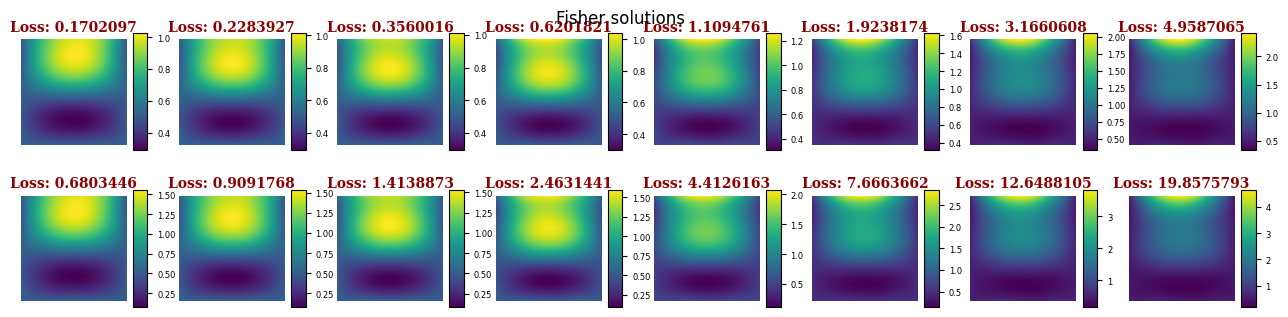

In [35]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in KG_loss_list]);

In [63]:
def function_decorator4(A, k1, k2, b=0):
    def func(x, t):
        return A*torch.sin(k1*torch.pi*x)*torch.sin(k2*torch.pi*t) + b
    return func

def forcing_decorator4(A, k1, k2, landa, b=0):
    func = function_decorator4(A, k1, k2, b)
    def force(x, t):
        u = func(x, t)
        return -A*(k1**2+k2**2)*(torch.pi**2)*torch.sin(k1*torch.pi*x)*torch.sin(k2*torch.pi*t) + landa*u**2
    return force

In [64]:
A_list = [-0.5, 0.5]; k1 = 2
K2_list = np.linspace(1, 2, 8)
landa = 0.8; b = 3; p = 35

manufactured_list = []
perturbation_list = []
KG_loss_list = []
mse_list = []

for A in A_list:
    for k2 in K2_list:
        ##compute the Perturbation solutions
        force = forcing_decorator4(A, k1, k2, landa, b=b)
        f0_values = force(x, t).detach().numpy()
        result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
        perturbation_list.append(result['sol'])
        ##compute the truth solutions
        truth_func = function_decorator4(A, k1, k2, b=b)
        truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
        manufactured_list.append(truth)
        ##compute mse for each one
        mse_list.append(((truth - result['sol'])**2).mean())
        ##compute the KG loss
        KG_loss_list.append(KG_loss(model, result['W'], landa, force, b0=b))
        

Function finisheds in 0.179072 seconds. On average, each PDE is solved using 0.004974 seconds
Function finisheds in 0.170676 seconds. On average, each PDE is solved using 0.004741 seconds
Function finisheds in 0.181086 seconds. On average, each PDE is solved using 0.00503 seconds
Function finisheds in 0.168547 seconds. On average, each PDE is solved using 0.004682 seconds
Function finisheds in 0.140042 seconds. On average, each PDE is solved using 0.00389 seconds
Function finisheds in 0.187613 seconds. On average, each PDE is solved using 0.005211 seconds
Function finisheds in 0.16534 seconds. On average, each PDE is solved using 0.004593 seconds
Function finisheds in 0.194103 seconds. On average, each PDE is solved using 0.005392 seconds
Function finisheds in 0.176298 seconds. On average, each PDE is solved using 0.004897 seconds
Function finisheds in 0.167884 seconds. On average, each PDE is solved using 0.004663 seconds
Function finisheds in 0.17285 seconds. On average, each PDE is 

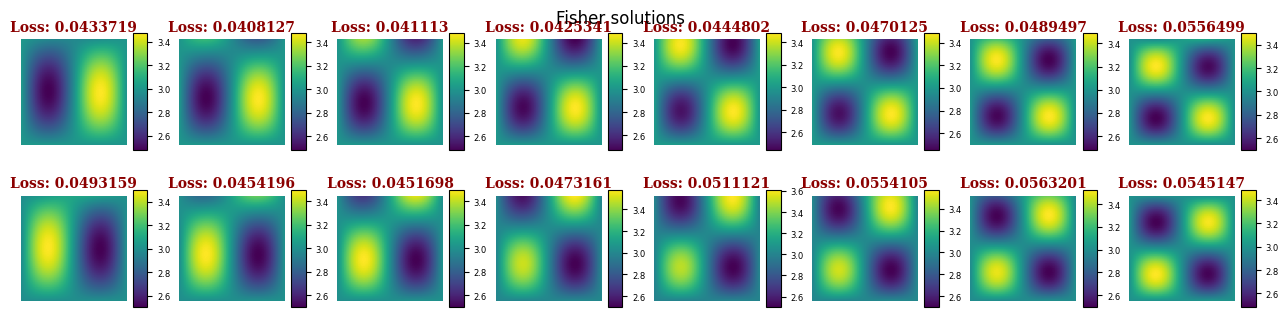

In [65]:
plot_solutions16(perturbation_list, 'Fisher solutions', 
                subtitle_list = ["Loss: " + str(round(l['total_loss'], 7)) for l in KG_loss_list]);

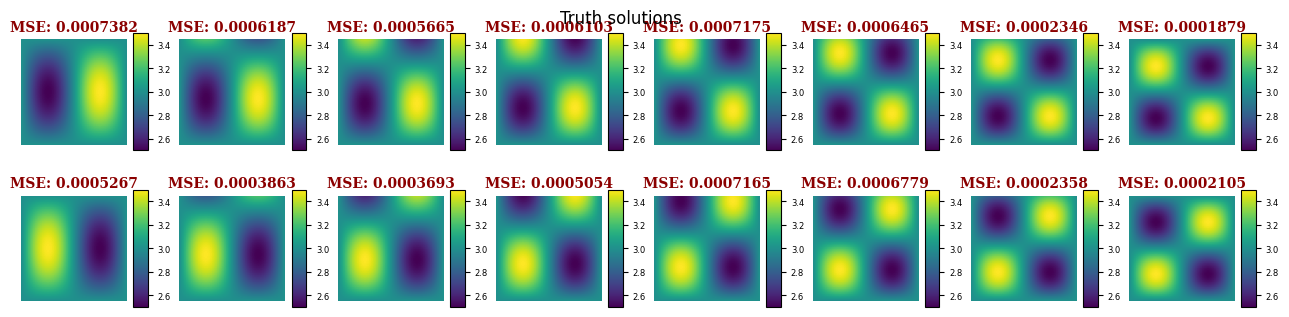

In [66]:
plot_solutions16(manufactured_list, 'Truth solutions', subtitle_list = ["MSE: " + str(round(mse, 7)) for mse in mse_list]);

In [67]:
##print 1. mean fisher loss 2. mean relative pde residual 3. mean BC condition loss 4. mean relative error
print("Average Fisher's Loss: ", np.mean([l['total_loss'] for l in KG_loss_list]))
#print("Average Relative PDE residual diff: ", np.mean([l['relative_pde_loss'] for l in KG_loss_list]))
#print("Average Relative BC loss: ", np.mean([l['relative_bc_loss'] for l in KG_loss_list]))
relative_error = abs(np.array(perturbation_list) - np.array(manufactured_list)).mean()/abs(np.array(manufactured_list)).mean()
print("Mean relative error: ", relative_error)
print("Mean MSE: ", np.mean(mse_list))

Average Fisher's Loss:  0.04803141008117519
Mean relative error:  0.0048602588397573645
Mean MSE:  0.0004967915850636036


In [68]:
indices = [0, 2, 4, 6, 8, 10, 12, 14]
TL_solution = np.array(perturbation_list)[indices]
truth_solution = np.array(manufactured_list)[indices]
import matplotlib.cm as cm
from matplotlib.colors import Normalize

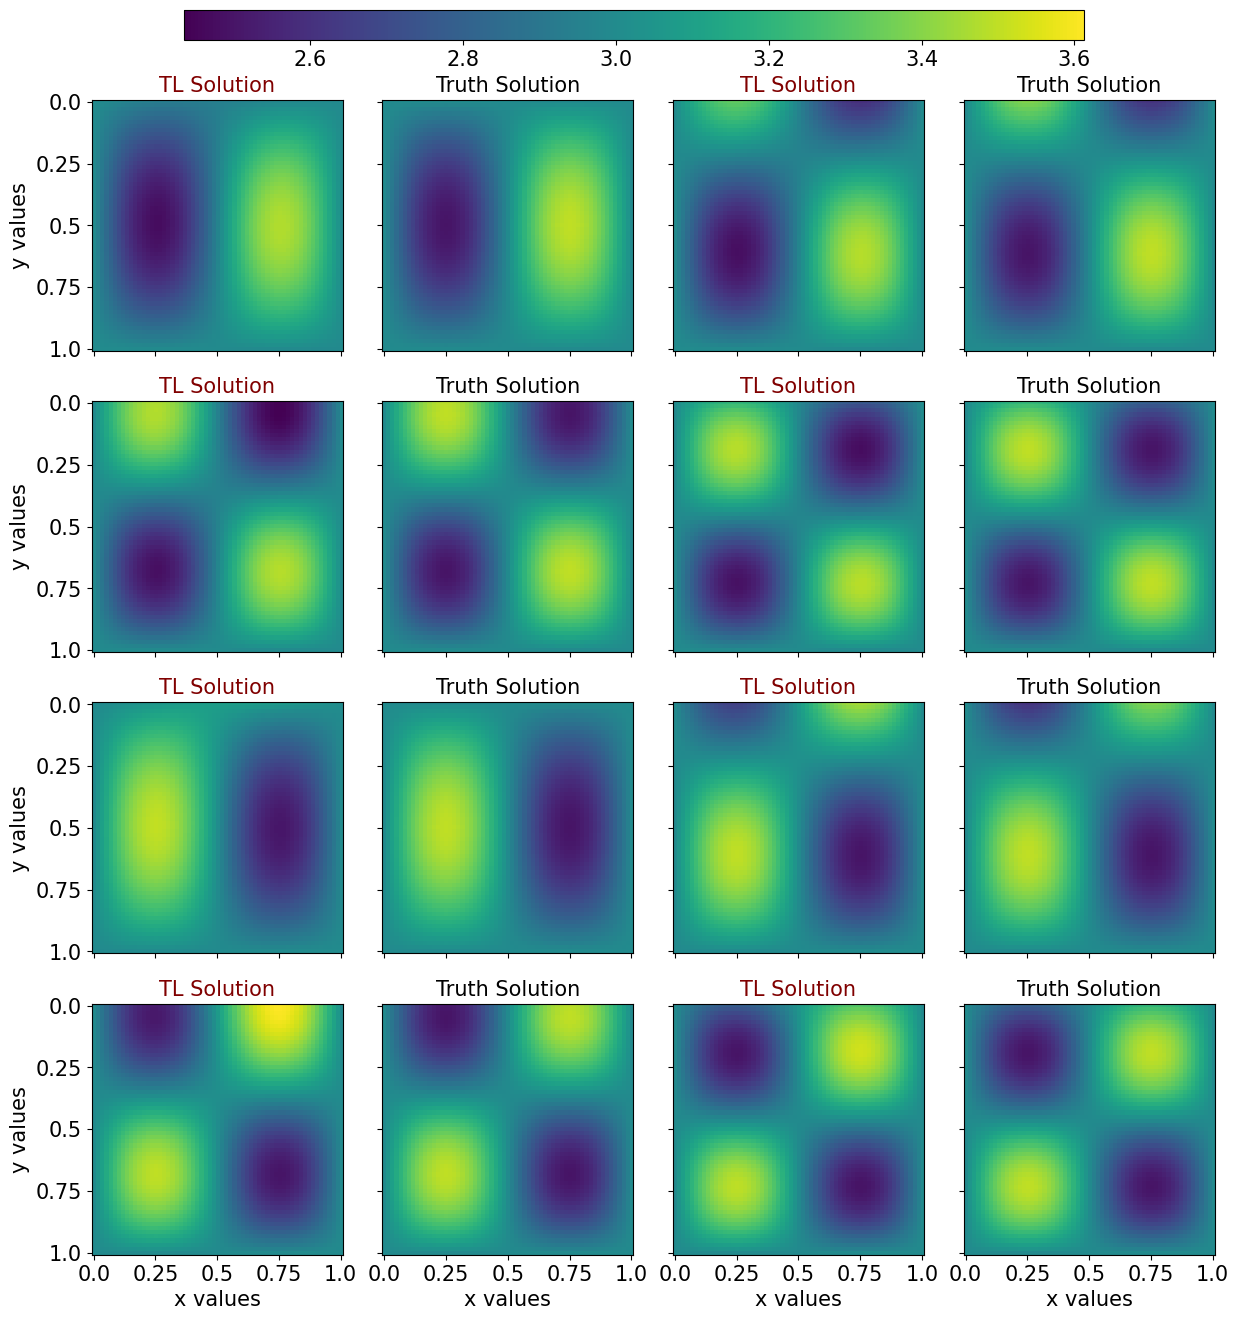

In [69]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15), sharex = True, sharey=True);
# Create color map
cmap = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min(min([result.min() for result in TL_solution]), min([result.min() for result in truth_solution]))
global_max = max(max([result.max() for result in TL_solution]), max([result.max() for result in truth_solution]))
normalizer = Normalize(global_min, global_max)
im = cm.ScalarMappable(norm=normalizer)

for i, tl in enumerate(TL_solution):
    j = i//2; k = 2*(i%2)
    ax[j][k].imshow(tl[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("TL Solution", fontsize=15, color='maroon');
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
for i, truth in enumerate(truth_solution):
    j = i//2; k = 2*(i%2)+1
    ax[j][k].imshow(truth[::-1, :], cmap=cmap, norm=normalizer)
    ax[j][k].set_title("Truth Solution", fontsize=15);
    ax[j][k].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)
    ax[j][k].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=15)

# Create a color bar axis
cax = fig.add_axes([0.2, 0.92, 0.6, 0.02])  # [left, bottom, width, height]
# Create the color bar
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), cax=cax, orientation='horizontal')
cbar.ax.tick_params(labelsize=15)
plt.subplots_adjust(wspace=0.0)

for i in range(4):
    ax[3][i].set_xlabel('x values', fontsize=15)
    ax[i][0].set_ylabel('y values', fontsize=15)

plt.savefig('KG_result.png',dpi=500, bbox_inches='tight')

In [192]:
A_list = [-0.5, 0.5]; k1 = 2
K2_list = np.linspace(1, 2, 8)
landa = 0.8; b = 3; 
KG_p = []
mse_p = []

for p in tqdm(range(1, 66)):
    manufactured_list = []
    perturbation_list = []
    KG_loss_list = []
    mse_list = []
    
    
    for A in A_list:
        for k2 in K2_list:
            ##compute the Perturbation solutions
            force = forcing_decorator4(A, k1, k2, landa, b=b)
            f0_values = force(x, t).detach().numpy()
            result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
            perturbation_list.append(result['sol'])
            ##compute the truth solutions
            truth_func = function_decorator4(A, k1, k2, b=b)
            truth = truth_func(X_grid[:,0], X_grid[:, 1]).reshape(61, -1).detach().numpy()
            manufactured_list.append(truth)
            ##compute mse for each one
            mse_list.append(((truth - result['sol'])**2).mean())
            ##compute the KG loss
            KG_loss_list.append(KG_loss(model, result['W'], landa, force, b0=b))
    KG_p.append(np.mean([l['total_loss'] for l in KG_loss_list]))
    mse_p.append(np.mean(mse_list))
            

  0%|                                                    | 0/65 [00:00<?, ?it/s]

Function finisheds in 0.018735 seconds. On average, each PDE is solved using 0.009368 seconds
Function finisheds in 0.00829 seconds. On average, each PDE is solved using 0.004145 seconds
Function finisheds in 0.005389 seconds. On average, each PDE is solved using 0.002695 seconds
Function finisheds in 0.007224 seconds. On average, each PDE is solved using 0.003612 seconds
Function finisheds in 0.005446 seconds. On average, each PDE is solved using 0.002723 seconds
Function finisheds in 0.006102 seconds. On average, each PDE is solved using 0.003051 seconds
Function finisheds in 0.005208 seconds. On average, each PDE is solved using 0.002604 seconds
Function finisheds in 0.005139 seconds. On average, each PDE is solved using 0.00257 seconds
Function finisheds in 0.006452 seconds. On average, each PDE is solved using 0.003226 seconds
Function finisheds in 0.005661 seconds. On average, each PDE is solved using 0.002831 seconds
Function finisheds in 0.006256 seconds. On average, each PDE i

  2%|▋                                           | 1/65 [00:07<08:18,  7.79s/it]

Function finisheds in 0.027343 seconds. On average, each PDE is solved using 0.009114 seconds
Function finisheds in 0.008436 seconds. On average, each PDE is solved using 0.002812 seconds
Function finisheds in 0.041962 seconds. On average, each PDE is solved using 0.013987 seconds
Function finisheds in 0.008807 seconds. On average, each PDE is solved using 0.002936 seconds
Function finisheds in 0.008431 seconds. On average, each PDE is solved using 0.00281 seconds
Function finisheds in 0.008506 seconds. On average, each PDE is solved using 0.002835 seconds
Function finisheds in 0.008244 seconds. On average, each PDE is solved using 0.002748 seconds
Function finisheds in 0.008495 seconds. On average, each PDE is solved using 0.002832 seconds
Function finisheds in 0.008553 seconds. On average, each PDE is solved using 0.002851 seconds
Function finisheds in 0.008405 seconds. On average, each PDE is solved using 0.002802 seconds
Function finisheds in 0.008482 seconds. On average, each PDE 

  3%|█▎                                          | 2/65 [00:15<08:13,  7.84s/it]

Function finisheds in 0.018343 seconds. On average, each PDE is solved using 0.004586 seconds
Function finisheds in 0.010586 seconds. On average, each PDE is solved using 0.002647 seconds
Function finisheds in 0.015171 seconds. On average, each PDE is solved using 0.003793 seconds
Function finisheds in 0.012679 seconds. On average, each PDE is solved using 0.00317 seconds
Function finisheds in 0.013134 seconds. On average, each PDE is solved using 0.003283 seconds
Function finisheds in 0.012406 seconds. On average, each PDE is solved using 0.003102 seconds
Function finisheds in 0.014448 seconds. On average, each PDE is solved using 0.003612 seconds
Function finisheds in 0.011884 seconds. On average, each PDE is solved using 0.002971 seconds
Function finisheds in 0.012585 seconds. On average, each PDE is solved using 0.003146 seconds
Function finisheds in 0.011805 seconds. On average, each PDE is solved using 0.002951 seconds
Function finisheds in 0.012782 seconds. On average, each PDE 

  5%|██                                          | 3/65 [00:23<08:07,  7.87s/it]

Function finisheds in 0.02908 seconds. On average, each PDE is solved using 0.005816 seconds
Function finisheds in 0.019899 seconds. On average, each PDE is solved using 0.00398 seconds
Function finisheds in 0.020859 seconds. On average, each PDE is solved using 0.004172 seconds
Function finisheds in 0.016564 seconds. On average, each PDE is solved using 0.003313 seconds
Function finisheds in 0.019865 seconds. On average, each PDE is solved using 0.003973 seconds
Function finisheds in 0.018328 seconds. On average, each PDE is solved using 0.003666 seconds
Function finisheds in 0.019972 seconds. On average, each PDE is solved using 0.003994 seconds
Function finisheds in 0.014397 seconds. On average, each PDE is solved using 0.002879 seconds
Function finisheds in 0.026606 seconds. On average, each PDE is solved using 0.005321 seconds
Function finisheds in 0.02467 seconds. On average, each PDE is solved using 0.004934 seconds
Function finisheds in 0.014603 seconds. On average, each PDE is

  6%|██▋                                         | 4/65 [00:31<08:01,  7.89s/it]

Function finisheds in 0.027699 seconds. On average, each PDE is solved using 0.004616 seconds
Function finisheds in 0.018922 seconds. On average, each PDE is solved using 0.003154 seconds
Function finisheds in 0.0182 seconds. On average, each PDE is solved using 0.003033 seconds
Function finisheds in 0.026252 seconds. On average, each PDE is solved using 0.004375 seconds
Function finisheds in 0.017606 seconds. On average, each PDE is solved using 0.002934 seconds
Function finisheds in 0.018298 seconds. On average, each PDE is solved using 0.00305 seconds
Function finisheds in 0.018099 seconds. On average, each PDE is solved using 0.003017 seconds
Function finisheds in 0.018837 seconds. On average, each PDE is solved using 0.003139 seconds
Function finisheds in 0.018056 seconds. On average, each PDE is solved using 0.003009 seconds
Function finisheds in 0.018318 seconds. On average, each PDE is solved using 0.003053 seconds
Function finisheds in 0.01811 seconds. On average, each PDE is 

  8%|███▍                                        | 5/65 [00:39<07:54,  7.91s/it]

Function finisheds in 0.02867 seconds. On average, each PDE is solved using 0.004096 seconds
Function finisheds in 0.022349 seconds. On average, each PDE is solved using 0.003193 seconds
Function finisheds in 0.031208 seconds. On average, each PDE is solved using 0.004458 seconds
Function finisheds in 0.019499 seconds. On average, each PDE is solved using 0.002786 seconds
Function finisheds in 0.019541 seconds. On average, each PDE is solved using 0.002792 seconds
Function finisheds in 0.032754 seconds. On average, each PDE is solved using 0.004679 seconds
Function finisheds in 0.022979 seconds. On average, each PDE is solved using 0.003283 seconds
Function finisheds in 0.030198 seconds. On average, each PDE is solved using 0.004314 seconds
Function finisheds in 0.020254 seconds. On average, each PDE is solved using 0.002893 seconds
Function finisheds in 0.020138 seconds. On average, each PDE is solved using 0.002877 seconds
Function finisheds in 0.031047 seconds. On average, each PDE 

  9%|████                                        | 6/65 [00:47<07:47,  7.92s/it]

Function finisheds in 0.044839 seconds. On average, each PDE is solved using 0.005605 seconds
Function finisheds in 0.097498 seconds. On average, each PDE is solved using 0.012187 seconds
Function finisheds in 0.036453 seconds. On average, each PDE is solved using 0.004557 seconds
Function finisheds in 0.039697 seconds. On average, each PDE is solved using 0.004962 seconds
Function finisheds in 0.031848 seconds. On average, each PDE is solved using 0.003981 seconds
Function finisheds in 0.037531 seconds. On average, each PDE is solved using 0.004691 seconds
Function finisheds in 0.029989 seconds. On average, each PDE is solved using 0.003749 seconds
Function finisheds in 0.03612 seconds. On average, each PDE is solved using 0.004515 seconds
Function finisheds in 0.036334 seconds. On average, each PDE is solved using 0.004542 seconds
Function finisheds in 0.037816 seconds. On average, each PDE is solved using 0.004727 seconds
Function finisheds in 0.036273 seconds. On average, each PDE 

 11%|████▋                                       | 7/65 [00:55<07:46,  8.04s/it]

Function finisheds in 0.045419 seconds. On average, each PDE is solved using 0.005047 seconds
Function finisheds in 0.038152 seconds. On average, each PDE is solved using 0.004239 seconds
Function finisheds in 0.037923 seconds. On average, each PDE is solved using 0.004214 seconds
Function finisheds in 0.032878 seconds. On average, each PDE is solved using 0.003653 seconds
Function finisheds in 0.043178 seconds. On average, each PDE is solved using 0.004798 seconds
Function finisheds in 0.038757 seconds. On average, each PDE is solved using 0.004306 seconds
Function finisheds in 0.039345 seconds. On average, each PDE is solved using 0.004372 seconds
Function finisheds in 0.034455 seconds. On average, each PDE is solved using 0.003828 seconds
Function finisheds in 0.039366 seconds. On average, each PDE is solved using 0.004374 seconds
Function finisheds in 0.026129 seconds. On average, each PDE is solved using 0.002903 seconds
Function finisheds in 0.034021 seconds. On average, each PDE

 12%|█████▍                                      | 8/65 [01:03<07:42,  8.12s/it]

Function finisheds in 0.039791 seconds. On average, each PDE is solved using 0.003979 seconds
Function finisheds in 0.051884 seconds. On average, each PDE is solved using 0.005188 seconds
Function finisheds in 0.043888 seconds. On average, each PDE is solved using 0.004389 seconds
Function finisheds in 0.040104 seconds. On average, each PDE is solved using 0.00401 seconds
Function finisheds in 0.031949 seconds. On average, each PDE is solved using 0.003195 seconds
Function finisheds in 0.039441 seconds. On average, each PDE is solved using 0.003944 seconds
Function finisheds in 0.045689 seconds. On average, each PDE is solved using 0.004569 seconds
Function finisheds in 0.061996 seconds. On average, each PDE is solved using 0.0062 seconds
Function finisheds in 0.060394 seconds. On average, each PDE is solved using 0.006039 seconds
Function finisheds in 0.042169 seconds. On average, each PDE is solved using 0.004217 seconds
Function finisheds in 0.041715 seconds. On average, each PDE is

 14%|██████                                      | 9/65 [01:12<07:36,  8.14s/it]

Function finisheds in 0.042533 seconds. On average, each PDE is solved using 0.003867 seconds
Function finisheds in 0.037862 seconds. On average, each PDE is solved using 0.003442 seconds
Function finisheds in 0.033379 seconds. On average, each PDE is solved using 0.003034 seconds
Function finisheds in 0.033444 seconds. On average, each PDE is solved using 0.00304 seconds
Function finisheds in 0.048207 seconds. On average, each PDE is solved using 0.004382 seconds
Function finisheds in 0.034958 seconds. On average, each PDE is solved using 0.003178 seconds
Function finisheds in 0.041848 seconds. On average, each PDE is solved using 0.003804 seconds
Function finisheds in 0.099774 seconds. On average, each PDE is solved using 0.00907 seconds
Function finisheds in 0.043512 seconds. On average, each PDE is solved using 0.003956 seconds
Function finisheds in 0.033979 seconds. On average, each PDE is solved using 0.003089 seconds
Function finisheds in 0.049927 seconds. On average, each PDE i

 15%|██████▌                                    | 10/65 [01:20<07:31,  8.21s/it]

Function finisheds in 0.058846 seconds. On average, each PDE is solved using 0.004904 seconds
Function finisheds in 0.050197 seconds. On average, each PDE is solved using 0.004183 seconds
Function finisheds in 0.044465 seconds. On average, each PDE is solved using 0.003705 seconds
Function finisheds in 0.040999 seconds. On average, each PDE is solved using 0.003417 seconds
Function finisheds in 0.055606 seconds. On average, each PDE is solved using 0.004634 seconds
Function finisheds in 0.05161 seconds. On average, each PDE is solved using 0.004301 seconds
Function finisheds in 0.050233 seconds. On average, each PDE is solved using 0.004186 seconds
Function finisheds in 0.055751 seconds. On average, each PDE is solved using 0.004646 seconds
Function finisheds in 0.04996 seconds. On average, each PDE is solved using 0.004163 seconds
Function finisheds in 0.052156 seconds. On average, each PDE is solved using 0.004346 seconds
Function finisheds in 0.053524 seconds. On average, each PDE i

 17%|███████▎                                   | 11/65 [01:29<07:28,  8.30s/it]

Function finisheds in 0.06606 seconds. On average, each PDE is solved using 0.005082 seconds
Function finisheds in 0.052671 seconds. On average, each PDE is solved using 0.004052 seconds
Function finisheds in 0.052115 seconds. On average, each PDE is solved using 0.004009 seconds
Function finisheds in 0.129515 seconds. On average, each PDE is solved using 0.009963 seconds
Function finisheds in 0.049253 seconds. On average, each PDE is solved using 0.003789 seconds
Function finisheds in 0.069065 seconds. On average, each PDE is solved using 0.005313 seconds
Function finisheds in 0.062518 seconds. On average, each PDE is solved using 0.004809 seconds
Function finisheds in 0.06648 seconds. On average, each PDE is solved using 0.005114 seconds
Function finisheds in 0.064715 seconds. On average, each PDE is solved using 0.004978 seconds
Function finisheds in 0.059766 seconds. On average, each PDE is solved using 0.004597 seconds
Function finisheds in 0.052767 seconds. On average, each PDE i

 18%|███████▉                                   | 12/65 [01:37<07:25,  8.41s/it]

Function finisheds in 0.074696 seconds. On average, each PDE is solved using 0.005335 seconds
Function finisheds in 0.055556 seconds. On average, each PDE is solved using 0.003968 seconds
Function finisheds in 0.054712 seconds. On average, each PDE is solved using 0.003908 seconds
Function finisheds in 0.05875 seconds. On average, each PDE is solved using 0.004196 seconds
Function finisheds in 0.052896 seconds. On average, each PDE is solved using 0.003778 seconds
Function finisheds in 0.06948 seconds. On average, each PDE is solved using 0.004963 seconds
Function finisheds in 0.054387 seconds. On average, each PDE is solved using 0.003885 seconds
Function finisheds in 0.059183 seconds. On average, each PDE is solved using 0.004227 seconds
Function finisheds in 0.053419 seconds. On average, each PDE is solved using 0.003816 seconds
Function finisheds in 0.05424 seconds. On average, each PDE is solved using 0.003874 seconds
Function finisheds in 0.05645 seconds. On average, each PDE is 

 20%|████████▌                                  | 13/65 [01:46<07:21,  8.49s/it]

Function finisheds in 0.065877 seconds. On average, each PDE is solved using 0.004392 seconds
Function finisheds in 0.071238 seconds. On average, each PDE is solved using 0.004749 seconds
Function finisheds in 0.067718 seconds. On average, each PDE is solved using 0.004515 seconds
Function finisheds in 0.068281 seconds. On average, each PDE is solved using 0.004552 seconds
Function finisheds in 0.062095 seconds. On average, each PDE is solved using 0.00414 seconds
Function finisheds in 0.063483 seconds. On average, each PDE is solved using 0.004232 seconds
Function finisheds in 0.072405 seconds. On average, each PDE is solved using 0.004827 seconds
Function finisheds in 0.064389 seconds. On average, each PDE is solved using 0.004293 seconds
Function finisheds in 0.066206 seconds. On average, each PDE is solved using 0.004414 seconds
Function finisheds in 0.064165 seconds. On average, each PDE is solved using 0.004278 seconds
Function finisheds in 0.073301 seconds. On average, each PDE 

 22%|█████████▎                                 | 14/65 [01:55<07:16,  8.56s/it]

Function finisheds in 0.088056 seconds. On average, each PDE is solved using 0.005504 seconds
Function finisheds in 0.072908 seconds. On average, each PDE is solved using 0.004557 seconds
Function finisheds in 0.065609 seconds. On average, each PDE is solved using 0.004101 seconds
Function finisheds in 0.064655 seconds. On average, each PDE is solved using 0.004041 seconds
Function finisheds in 0.068534 seconds. On average, each PDE is solved using 0.004283 seconds
Function finisheds in 0.064505 seconds. On average, each PDE is solved using 0.004032 seconds
Function finisheds in 0.073624 seconds. On average, each PDE is solved using 0.004601 seconds
Function finisheds in 0.066687 seconds. On average, each PDE is solved using 0.004168 seconds
Function finisheds in 0.092759 seconds. On average, each PDE is solved using 0.005797 seconds
Function finisheds in 0.06842 seconds. On average, each PDE is solved using 0.004276 seconds
Function finisheds in 0.069928 seconds. On average, each PDE 

 23%|█████████▉                                 | 15/65 [02:03<07:11,  8.63s/it]

Function finisheds in 0.087155 seconds. On average, each PDE is solved using 0.005127 seconds
Function finisheds in 0.075055 seconds. On average, each PDE is solved using 0.004415 seconds
Function finisheds in 0.07545 seconds. On average, each PDE is solved using 0.004438 seconds
Function finisheds in 0.070934 seconds. On average, each PDE is solved using 0.004173 seconds
Function finisheds in 0.06665 seconds. On average, each PDE is solved using 0.003921 seconds
Function finisheds in 0.085395 seconds. On average, each PDE is solved using 0.005023 seconds
Function finisheds in 0.069305 seconds. On average, each PDE is solved using 0.004077 seconds
Function finisheds in 0.073244 seconds. On average, each PDE is solved using 0.004308 seconds
Function finisheds in 0.070746 seconds. On average, each PDE is solved using 0.004162 seconds
Function finisheds in 0.057357 seconds. On average, each PDE is solved using 0.003374 seconds
Function finisheds in 0.084014 seconds. On average, each PDE i

 25%|██████████▌                                | 16/65 [02:12<07:06,  8.70s/it]

Function finisheds in 0.097703 seconds. On average, each PDE is solved using 0.005428 seconds
Function finisheds in 0.078534 seconds. On average, each PDE is solved using 0.004363 seconds
Function finisheds in 0.070343 seconds. On average, each PDE is solved using 0.003908 seconds
Function finisheds in 0.076979 seconds. On average, each PDE is solved using 0.004277 seconds
Function finisheds in 0.083636 seconds. On average, each PDE is solved using 0.004646 seconds
Function finisheds in 0.075689 seconds. On average, each PDE is solved using 0.004205 seconds
Function finisheds in 0.081206 seconds. On average, each PDE is solved using 0.004511 seconds
Function finisheds in 0.081107 seconds. On average, each PDE is solved using 0.004506 seconds
Function finisheds in 0.089759 seconds. On average, each PDE is solved using 0.004987 seconds
Function finisheds in 0.089296 seconds. On average, each PDE is solved using 0.004961 seconds
Function finisheds in 0.075288 seconds. On average, each PDE

 26%|███████████▏                               | 17/65 [02:21<07:03,  8.81s/it]

Function finisheds in 0.083163 seconds. On average, each PDE is solved using 0.004377 seconds
Function finisheds in 0.100801 seconds. On average, each PDE is solved using 0.005305 seconds
Function finisheds in 0.086087 seconds. On average, each PDE is solved using 0.004531 seconds
Function finisheds in 0.085053 seconds. On average, each PDE is solved using 0.004476 seconds
Function finisheds in 0.092306 seconds. On average, each PDE is solved using 0.004858 seconds
Function finisheds in 0.097094 seconds. On average, each PDE is solved using 0.00511 seconds
Function finisheds in 0.093566 seconds. On average, each PDE is solved using 0.004925 seconds
Function finisheds in 0.087755 seconds. On average, each PDE is solved using 0.004619 seconds
Function finisheds in 0.077126 seconds. On average, each PDE is solved using 0.004059 seconds
Function finisheds in 0.090142 seconds. On average, each PDE is solved using 0.004744 seconds
Function finisheds in 0.082655 seconds. On average, each PDE 

 28%|███████████▉                               | 18/65 [02:30<06:57,  8.88s/it]

Function finisheds in 0.120936 seconds. On average, each PDE is solved using 0.006047 seconds
Function finisheds in 0.091698 seconds. On average, each PDE is solved using 0.004585 seconds
Function finisheds in 0.095955 seconds. On average, each PDE is solved using 0.004798 seconds
Function finisheds in 0.0921 seconds. On average, each PDE is solved using 0.004605 seconds
Function finisheds in 0.092014 seconds. On average, each PDE is solved using 0.004601 seconds
Function finisheds in 0.076742 seconds. On average, each PDE is solved using 0.003837 seconds
Function finisheds in 0.096237 seconds. On average, each PDE is solved using 0.004812 seconds
Function finisheds in 0.081694 seconds. On average, each PDE is solved using 0.004085 seconds
Function finisheds in 0.088336 seconds. On average, each PDE is solved using 0.004417 seconds
Function finisheds in 0.074795 seconds. On average, each PDE is solved using 0.00374 seconds
Function finisheds in 0.061294 seconds. On average, each PDE is

 29%|████████████▌                              | 19/65 [02:39<06:49,  8.91s/it]

Function finisheds in 0.091078 seconds. On average, each PDE is solved using 0.004337 seconds
Function finisheds in 0.096951 seconds. On average, each PDE is solved using 0.004617 seconds
Function finisheds in 0.085802 seconds. On average, each PDE is solved using 0.004086 seconds
Function finisheds in 0.100383 seconds. On average, each PDE is solved using 0.00478 seconds
Function finisheds in 0.093385 seconds. On average, each PDE is solved using 0.004447 seconds
Function finisheds in 0.08526 seconds. On average, each PDE is solved using 0.00406 seconds
Function finisheds in 0.088403 seconds. On average, each PDE is solved using 0.00421 seconds
Function finisheds in 0.103864 seconds. On average, each PDE is solved using 0.004946 seconds
Function finisheds in 0.070237 seconds. On average, each PDE is solved using 0.003345 seconds
Function finisheds in 0.095751 seconds. On average, each PDE is solved using 0.00456 seconds
Function finisheds in 0.076411 seconds. On average, each PDE is s

 31%|█████████████▏                             | 20/65 [02:48<06:43,  8.97s/it]

Function finisheds in 0.105731 seconds. On average, each PDE is solved using 0.004806 seconds
Function finisheds in 0.098118 seconds. On average, each PDE is solved using 0.00446 seconds
Function finisheds in 0.097803 seconds. On average, each PDE is solved using 0.004446 seconds
Function finisheds in 0.116848 seconds. On average, each PDE is solved using 0.005311 seconds
Function finisheds in 0.097416 seconds. On average, each PDE is solved using 0.004428 seconds
Function finisheds in 0.085845 seconds. On average, each PDE is solved using 0.003902 seconds
Function finisheds in 0.081187 seconds. On average, each PDE is solved using 0.00369 seconds
Function finisheds in 0.120526 seconds. On average, each PDE is solved using 0.005478 seconds
Function finisheds in 0.104519 seconds. On average, each PDE is solved using 0.004751 seconds
Function finisheds in 0.112026 seconds. On average, each PDE is solved using 0.005092 seconds
Function finisheds in 0.115883 seconds. On average, each PDE i

 32%|█████████████▉                             | 21/65 [02:58<06:38,  9.06s/it]

Function finisheds in 0.096862 seconds. On average, each PDE is solved using 0.004211 seconds
Function finisheds in 0.081371 seconds. On average, each PDE is solved using 0.003538 seconds
Function finisheds in 0.099993 seconds. On average, each PDE is solved using 0.004348 seconds
Function finisheds in 0.102671 seconds. On average, each PDE is solved using 0.004464 seconds
Function finisheds in 0.092775 seconds. On average, each PDE is solved using 0.004034 seconds
Function finisheds in 0.099495 seconds. On average, each PDE is solved using 0.004326 seconds
Function finisheds in 0.103912 seconds. On average, each PDE is solved using 0.004518 seconds
Function finisheds in 0.122401 seconds. On average, each PDE is solved using 0.005322 seconds
Function finisheds in 0.090156 seconds. On average, each PDE is solved using 0.00392 seconds
Function finisheds in 0.096851 seconds. On average, each PDE is solved using 0.004211 seconds
Function finisheds in 0.095283 seconds. On average, each PDE 

 34%|██████████████▌                            | 22/65 [03:07<06:31,  9.10s/it]

Function finisheds in 0.124267 seconds. On average, each PDE is solved using 0.005178 seconds
Function finisheds in 0.09065 seconds. On average, each PDE is solved using 0.003777 seconds
Function finisheds in 0.126221 seconds. On average, each PDE is solved using 0.005259 seconds
Function finisheds in 0.092612 seconds. On average, each PDE is solved using 0.003859 seconds
Function finisheds in 0.108532 seconds. On average, each PDE is solved using 0.004522 seconds
Function finisheds in 0.109405 seconds. On average, each PDE is solved using 0.004559 seconds
Function finisheds in 0.099151 seconds. On average, each PDE is solved using 0.004131 seconds
Function finisheds in 0.108581 seconds. On average, each PDE is solved using 0.004524 seconds
Function finisheds in 0.092466 seconds. On average, each PDE is solved using 0.003853 seconds
Function finisheds in 0.099188 seconds. On average, each PDE is solved using 0.004133 seconds
Function finisheds in 0.101202 seconds. On average, each PDE 

 35%|███████████████▏                           | 23/65 [03:16<06:25,  9.18s/it]

Function finisheds in 0.105658 seconds. On average, each PDE is solved using 0.004226 seconds
Function finisheds in 0.111898 seconds. On average, each PDE is solved using 0.004476 seconds
Function finisheds in 0.101531 seconds. On average, each PDE is solved using 0.004061 seconds
Function finisheds in 0.099746 seconds. On average, each PDE is solved using 0.00399 seconds
Function finisheds in 0.112591 seconds. On average, each PDE is solved using 0.004504 seconds
Function finisheds in 0.101431 seconds. On average, each PDE is solved using 0.004057 seconds
Function finisheds in 0.103493 seconds. On average, each PDE is solved using 0.00414 seconds
Function finisheds in 0.116397 seconds. On average, each PDE is solved using 0.004656 seconds
Function finisheds in 0.13737 seconds. On average, each PDE is solved using 0.005495 seconds
Function finisheds in 0.126697 seconds. On average, each PDE is solved using 0.005068 seconds
Function finisheds in 0.111421 seconds. On average, each PDE is

 37%|███████████████▉                           | 24/65 [03:26<06:19,  9.26s/it]

Function finisheds in 0.130239 seconds. On average, each PDE is solved using 0.005009 seconds
Function finisheds in 0.117129 seconds. On average, each PDE is solved using 0.004505 seconds
Function finisheds in 0.111637 seconds. On average, each PDE is solved using 0.004294 seconds
Function finisheds in 0.111597 seconds. On average, each PDE is solved using 0.004292 seconds
Function finisheds in 0.099038 seconds. On average, each PDE is solved using 0.003809 seconds
Function finisheds in 0.108251 seconds. On average, each PDE is solved using 0.004164 seconds
Function finisheds in 0.098906 seconds. On average, each PDE is solved using 0.003804 seconds
Function finisheds in 0.114109 seconds. On average, each PDE is solved using 0.004389 seconds
Function finisheds in 0.148481 seconds. On average, each PDE is solved using 0.005711 seconds
Function finisheds in 0.119538 seconds. On average, each PDE is solved using 0.004598 seconds
Function finisheds in 0.111363 seconds. On average, each PDE

 38%|████████████████▌                          | 25/65 [03:35<06:12,  9.32s/it]

Function finisheds in 0.131284 seconds. On average, each PDE is solved using 0.004862 seconds
Function finisheds in 0.117632 seconds. On average, each PDE is solved using 0.004357 seconds
Function finisheds in 0.109712 seconds. On average, each PDE is solved using 0.004063 seconds
Function finisheds in 0.117477 seconds. On average, each PDE is solved using 0.004351 seconds
Function finisheds in 0.141452 seconds. On average, each PDE is solved using 0.005239 seconds
Function finisheds in 0.110889 seconds. On average, each PDE is solved using 0.004107 seconds
Function finisheds in 0.13566 seconds. On average, each PDE is solved using 0.005024 seconds
Function finisheds in 0.115393 seconds. On average, each PDE is solved using 0.004274 seconds
Function finisheds in 0.111786 seconds. On average, each PDE is solved using 0.00414 seconds
Function finisheds in 0.11485 seconds. On average, each PDE is solved using 0.004254 seconds
Function finisheds in 0.12264 seconds. On average, each PDE is 

 40%|█████████████████▏                         | 26/65 [03:45<06:07,  9.41s/it]

Function finisheds in 0.143803 seconds. On average, each PDE is solved using 0.005136 seconds
Function finisheds in 0.121571 seconds. On average, each PDE is solved using 0.004342 seconds
Function finisheds in 0.125454 seconds. On average, each PDE is solved using 0.00448 seconds
Function finisheds in 0.128255 seconds. On average, each PDE is solved using 0.004581 seconds
Function finisheds in 0.121418 seconds. On average, each PDE is solved using 0.004336 seconds
Function finisheds in 0.114547 seconds. On average, each PDE is solved using 0.004091 seconds
Function finisheds in 0.129624 seconds. On average, each PDE is solved using 0.004629 seconds
Function finisheds in 0.108592 seconds. On average, each PDE is solved using 0.003878 seconds
Function finisheds in 0.106807 seconds. On average, each PDE is solved using 0.003815 seconds
Function finisheds in 0.118231 seconds. On average, each PDE is solved using 0.004223 seconds
Function finisheds in 0.095587 seconds. On average, each PDE 

 42%|█████████████████▊                         | 27/65 [03:54<05:59,  9.46s/it]

Function finisheds in 0.129853 seconds. On average, each PDE is solved using 0.004478 seconds
Function finisheds in 0.138542 seconds. On average, each PDE is solved using 0.004777 seconds
Function finisheds in 0.13085 seconds. On average, each PDE is solved using 0.004512 seconds
Function finisheds in 0.118434 seconds. On average, each PDE is solved using 0.004084 seconds
Function finisheds in 0.117894 seconds. On average, each PDE is solved using 0.004065 seconds
Function finisheds in 0.12964 seconds. On average, each PDE is solved using 0.00447 seconds
Function finisheds in 0.110822 seconds. On average, each PDE is solved using 0.003821 seconds
Function finisheds in 0.142345 seconds. On average, each PDE is solved using 0.004908 seconds
Function finisheds in 0.126777 seconds. On average, each PDE is solved using 0.004372 seconds
Function finisheds in 0.123967 seconds. On average, each PDE is solved using 0.004275 seconds
Function finisheds in 0.116584 seconds. On average, each PDE is

 43%|██████████████████▌                        | 28/65 [04:04<05:53,  9.55s/it]

Function finisheds in 0.142179 seconds. On average, each PDE is solved using 0.004739 seconds
Function finisheds in 0.127373 seconds. On average, each PDE is solved using 0.004246 seconds
Function finisheds in 0.127346 seconds. On average, each PDE is solved using 0.004245 seconds
Function finisheds in 0.138015 seconds. On average, each PDE is solved using 0.004601 seconds
Function finisheds in 0.128602 seconds. On average, each PDE is solved using 0.004287 seconds
Function finisheds in 0.146111 seconds. On average, each PDE is solved using 0.00487 seconds
Function finisheds in 0.130056 seconds. On average, each PDE is solved using 0.004335 seconds
Function finisheds in 0.138185 seconds. On average, each PDE is solved using 0.004606 seconds
Function finisheds in 0.122178 seconds. On average, each PDE is solved using 0.004073 seconds
Function finisheds in 0.128777 seconds. On average, each PDE is solved using 0.004293 seconds
Function finisheds in 0.128309 seconds. On average, each PDE 

 45%|███████████████████▏                       | 29/65 [04:14<05:47,  9.65s/it]

Function finisheds in 0.159 seconds. On average, each PDE is solved using 0.005129 seconds
Function finisheds in 0.127731 seconds. On average, each PDE is solved using 0.00412 seconds
Function finisheds in 0.129368 seconds. On average, each PDE is solved using 0.004173 seconds
Function finisheds in 0.12807 seconds. On average, each PDE is solved using 0.004131 seconds
Function finisheds in 0.138043 seconds. On average, each PDE is solved using 0.004453 seconds
Function finisheds in 0.118936 seconds. On average, each PDE is solved using 0.003837 seconds
Function finisheds in 0.131391 seconds. On average, each PDE is solved using 0.004238 seconds
Function finisheds in 0.135474 seconds. On average, each PDE is solved using 0.00437 seconds
Function finisheds in 0.125718 seconds. On average, each PDE is solved using 0.004055 seconds
Function finisheds in 0.151851 seconds. On average, each PDE is solved using 0.004898 seconds
Function finisheds in 0.140649 seconds. On average, each PDE is so

 46%|███████████████████▊                       | 30/65 [04:24<05:39,  9.70s/it]

Function finisheds in 0.144906 seconds. On average, each PDE is solved using 0.004528 seconds
Function finisheds in 0.133028 seconds. On average, each PDE is solved using 0.004157 seconds
Function finisheds in 0.130881 seconds. On average, each PDE is solved using 0.00409 seconds
Function finisheds in 0.128456 seconds. On average, each PDE is solved using 0.004014 seconds
Function finisheds in 0.159048 seconds. On average, each PDE is solved using 0.00497 seconds
Function finisheds in 0.135778 seconds. On average, each PDE is solved using 0.004243 seconds
Function finisheds in 0.140385 seconds. On average, each PDE is solved using 0.004387 seconds
Function finisheds in 0.139976 seconds. On average, each PDE is solved using 0.004374 seconds
Function finisheds in 0.143495 seconds. On average, each PDE is solved using 0.004484 seconds
Function finisheds in 0.145067 seconds. On average, each PDE is solved using 0.004533 seconds
Function finisheds in 0.159377 seconds. On average, each PDE i

 48%|████████████████████▌                      | 31/65 [04:34<05:31,  9.76s/it]

Function finisheds in 0.158552 seconds. On average, each PDE is solved using 0.004805 seconds
Function finisheds in 0.130347 seconds. On average, each PDE is solved using 0.00395 seconds
Function finisheds in 0.144988 seconds. On average, each PDE is solved using 0.004394 seconds
Function finisheds in 0.157091 seconds. On average, each PDE is solved using 0.00476 seconds
Function finisheds in 0.216072 seconds. On average, each PDE is solved using 0.006548 seconds
Function finisheds in 0.13323 seconds. On average, each PDE is solved using 0.004037 seconds
Function finisheds in 0.142684 seconds. On average, each PDE is solved using 0.004324 seconds
Function finisheds in 0.191742 seconds. On average, each PDE is solved using 0.00581 seconds
Function finisheds in 0.140918 seconds. On average, each PDE is solved using 0.00427 seconds
Function finisheds in 0.144589 seconds. On average, each PDE is solved using 0.004381 seconds
Function finisheds in 0.126888 seconds. On average, each PDE is s

 49%|█████████████████████▏                     | 32/65 [04:44<05:25,  9.86s/it]

Function finisheds in 0.146078 seconds. On average, each PDE is solved using 0.004296 seconds
Function finisheds in 0.163973 seconds. On average, each PDE is solved using 0.004823 seconds
Function finisheds in 0.148287 seconds. On average, each PDE is solved using 0.004361 seconds
Function finisheds in 0.151402 seconds. On average, each PDE is solved using 0.004453 seconds
Function finisheds in 0.147762 seconds. On average, each PDE is solved using 0.004346 seconds
Function finisheds in 0.15706 seconds. On average, each PDE is solved using 0.004619 seconds
Function finisheds in 0.15621 seconds. On average, each PDE is solved using 0.004594 seconds
Function finisheds in 0.14402 seconds. On average, each PDE is solved using 0.004236 seconds
Function finisheds in 0.123044 seconds. On average, each PDE is solved using 0.003619 seconds
Function finisheds in 0.149596 seconds. On average, each PDE is solved using 0.0044 seconds
Function finisheds in 0.138299 seconds. On average, each PDE is s

 51%|█████████████████████▊                     | 33/65 [04:54<05:16,  9.88s/it]

Function finisheds in 0.16795 seconds. On average, each PDE is solved using 0.004799 seconds
Function finisheds in 0.171169 seconds. On average, each PDE is solved using 0.004891 seconds
Function finisheds in 0.16481 seconds. On average, each PDE is solved using 0.004709 seconds
Function finisheds in 0.185427 seconds. On average, each PDE is solved using 0.005298 seconds
Function finisheds in 0.145958 seconds. On average, each PDE is solved using 0.00417 seconds
Function finisheds in 0.155792 seconds. On average, each PDE is solved using 0.004451 seconds
Function finisheds in 0.145335 seconds. On average, each PDE is solved using 0.004152 seconds
Function finisheds in 0.147764 seconds. On average, each PDE is solved using 0.004222 seconds
Function finisheds in 0.153225 seconds. On average, each PDE is solved using 0.004378 seconds
Function finisheds in 0.164322 seconds. On average, each PDE is solved using 0.004695 seconds
Function finisheds in 0.142763 seconds. On average, each PDE is

 52%|██████████████████████▍                    | 34/65 [05:04<05:09,  9.97s/it]

Function finisheds in 0.157231 seconds. On average, each PDE is solved using 0.004368 seconds
Function finisheds in 0.150826 seconds. On average, each PDE is solved using 0.00419 seconds
Function finisheds in 0.168322 seconds. On average, each PDE is solved using 0.004676 seconds
Function finisheds in 0.16337 seconds. On average, each PDE is solved using 0.004538 seconds
Function finisheds in 0.149668 seconds. On average, each PDE is solved using 0.004157 seconds
Function finisheds in 0.159056 seconds. On average, each PDE is solved using 0.004418 seconds
Function finisheds in 0.164559 seconds. On average, each PDE is solved using 0.004571 seconds
Function finisheds in 0.172218 seconds. On average, each PDE is solved using 0.004784 seconds
Function finisheds in 0.168584 seconds. On average, each PDE is solved using 0.004683 seconds
Function finisheds in 0.152747 seconds. On average, each PDE is solved using 0.004243 seconds
Function finisheds in 0.181679 seconds. On average, each PDE i

 54%|███████████████████████▏                   | 35/65 [05:14<05:01, 10.06s/it]

Function finisheds in 0.162116 seconds. On average, each PDE is solved using 0.004382 seconds
Function finisheds in 0.172461 seconds. On average, each PDE is solved using 0.004661 seconds
Function finisheds in 0.283831 seconds. On average, each PDE is solved using 0.007671 seconds
Function finisheds in 0.431504 seconds. On average, each PDE is solved using 0.011662 seconds
Function finisheds in 0.332236 seconds. On average, each PDE is solved using 0.008979 seconds
Function finisheds in 0.321773 seconds. On average, each PDE is solved using 0.008697 seconds
Function finisheds in 0.322084 seconds. On average, each PDE is solved using 0.008705 seconds
Function finisheds in 0.398231 seconds. On average, each PDE is solved using 0.010763 seconds
Function finisheds in 0.369982 seconds. On average, each PDE is solved using 0.01 seconds
Function finisheds in 0.343256 seconds. On average, each PDE is solved using 0.009277 seconds
Function finisheds in 0.327779 seconds. On average, each PDE is 

 55%|███████████████████████▊                   | 36/65 [05:29<05:32, 11.47s/it]

Function finisheds in 0.268943 seconds. On average, each PDE is solved using 0.007077 seconds
Function finisheds in 0.194541 seconds. On average, each PDE is solved using 0.005119 seconds
Function finisheds in 0.248889 seconds. On average, each PDE is solved using 0.00655 seconds
Function finisheds in 0.185123 seconds. On average, each PDE is solved using 0.004872 seconds
Function finisheds in 0.219223 seconds. On average, each PDE is solved using 0.005769 seconds
Function finisheds in 0.199908 seconds. On average, each PDE is solved using 0.005261 seconds
Function finisheds in 0.197204 seconds. On average, each PDE is solved using 0.00519 seconds
Function finisheds in 0.230395 seconds. On average, each PDE is solved using 0.006063 seconds
Function finisheds in 0.155549 seconds. On average, each PDE is solved using 0.004093 seconds
Function finisheds in 0.192247 seconds. On average, each PDE is solved using 0.005059 seconds
Function finisheds in 0.222236 seconds. On average, each PDE i

 57%|████████████████████████▍                  | 37/65 [05:40<05:17, 11.34s/it]

Function finisheds in 0.177903 seconds. On average, each PDE is solved using 0.004562 seconds
Function finisheds in 0.17042 seconds. On average, each PDE is solved using 0.00437 seconds
Function finisheds in 0.175361 seconds. On average, each PDE is solved using 0.004496 seconds
Function finisheds in 0.159969 seconds. On average, each PDE is solved using 0.004102 seconds
Function finisheds in 0.154314 seconds. On average, each PDE is solved using 0.003957 seconds
Function finisheds in 0.169384 seconds. On average, each PDE is solved using 0.004343 seconds
Function finisheds in 0.145355 seconds. On average, each PDE is solved using 0.003727 seconds
Function finisheds in 0.160465 seconds. On average, each PDE is solved using 0.004114 seconds
Function finisheds in 0.161023 seconds. On average, each PDE is solved using 0.004129 seconds
Function finisheds in 0.187123 seconds. On average, each PDE is solved using 0.004798 seconds
Function finisheds in 0.159174 seconds. On average, each PDE i

 58%|█████████████████████████▏                 | 38/65 [05:50<04:58, 11.06s/it]

Function finisheds in 0.179761 seconds. On average, each PDE is solved using 0.004494 seconds
Function finisheds in 0.187316 seconds. On average, each PDE is solved using 0.004683 seconds
Function finisheds in 0.18839 seconds. On average, each PDE is solved using 0.00471 seconds
Function finisheds in 0.230933 seconds. On average, each PDE is solved using 0.005773 seconds
Function finisheds in 0.18685 seconds. On average, each PDE is solved using 0.004671 seconds
Function finisheds in 0.191874 seconds. On average, each PDE is solved using 0.004797 seconds
Function finisheds in 0.157982 seconds. On average, each PDE is solved using 0.00395 seconds
Function finisheds in 0.143696 seconds. On average, each PDE is solved using 0.003592 seconds
Function finisheds in 0.171192 seconds. On average, each PDE is solved using 0.00428 seconds
Function finisheds in 0.168615 seconds. On average, each PDE is solved using 0.004215 seconds
Function finisheds in 0.168498 seconds. On average, each PDE is s

 60%|█████████████████████████▊                 | 39/65 [06:01<04:44, 10.94s/it]

Function finisheds in 0.18586 seconds. On average, each PDE is solved using 0.004533 seconds
Function finisheds in 0.166634 seconds. On average, each PDE is solved using 0.004064 seconds
Function finisheds in 0.180439 seconds. On average, each PDE is solved using 0.004401 seconds
Function finisheds in 0.1724 seconds. On average, each PDE is solved using 0.004205 seconds
Function finisheds in 0.179629 seconds. On average, each PDE is solved using 0.004381 seconds
Function finisheds in 0.178701 seconds. On average, each PDE is solved using 0.004359 seconds
Function finisheds in 0.179333 seconds. On average, each PDE is solved using 0.004374 seconds
Function finisheds in 0.174512 seconds. On average, each PDE is solved using 0.004256 seconds
Function finisheds in 0.167095 seconds. On average, each PDE is solved using 0.004075 seconds
Function finisheds in 0.167076 seconds. On average, each PDE is solved using 0.004075 seconds
Function finisheds in 0.166073 seconds. On average, each PDE is

 62%|██████████████████████████▍                | 40/65 [06:12<04:30, 10.81s/it]

Function finisheds in 0.309972 seconds. On average, each PDE is solved using 0.00738 seconds
Function finisheds in 0.334604 seconds. On average, each PDE is solved using 0.007967 seconds
Function finisheds in 0.186122 seconds. On average, each PDE is solved using 0.004431 seconds
Function finisheds in 0.185407 seconds. On average, each PDE is solved using 0.004414 seconds
Function finisheds in 0.183123 seconds. On average, each PDE is solved using 0.00436 seconds
Function finisheds in 0.181083 seconds. On average, each PDE is solved using 0.004312 seconds
Function finisheds in 0.187429 seconds. On average, each PDE is solved using 0.004463 seconds
Function finisheds in 0.200019 seconds. On average, each PDE is solved using 0.004762 seconds
Function finisheds in 0.176471 seconds. On average, each PDE is solved using 0.004202 seconds
Function finisheds in 0.181823 seconds. On average, each PDE is solved using 0.004329 seconds
Function finisheds in 0.197334 seconds. On average, each PDE i

 63%|███████████████████████████                | 41/65 [06:22<04:19, 10.83s/it]

Function finisheds in 0.181385 seconds. On average, each PDE is solved using 0.004218 seconds
Function finisheds in 0.179428 seconds. On average, each PDE is solved using 0.004173 seconds
Function finisheds in 0.210928 seconds. On average, each PDE is solved using 0.004905 seconds
Function finisheds in 0.181761 seconds. On average, each PDE is solved using 0.004227 seconds
Function finisheds in 0.171747 seconds. On average, each PDE is solved using 0.003994 seconds
Function finisheds in 0.184873 seconds. On average, each PDE is solved using 0.004299 seconds
Function finisheds in 0.212213 seconds. On average, each PDE is solved using 0.004935 seconds
Function finisheds in 0.165535 seconds. On average, each PDE is solved using 0.00385 seconds
Function finisheds in 0.179565 seconds. On average, each PDE is solved using 0.004176 seconds
Function finisheds in 0.190233 seconds. On average, each PDE is solved using 0.004424 seconds
Function finisheds in 0.180426 seconds. On average, each PDE 

 65%|███████████████████████████▊               | 42/65 [06:33<04:07, 10.78s/it]

Function finisheds in 0.210573 seconds. On average, each PDE is solved using 0.004786 seconds
Function finisheds in 0.198436 seconds. On average, each PDE is solved using 0.00451 seconds
Function finisheds in 0.214533 seconds. On average, each PDE is solved using 0.004876 seconds
Function finisheds in 0.21476 seconds. On average, each PDE is solved using 0.004881 seconds
Function finisheds in 0.179198 seconds. On average, each PDE is solved using 0.004073 seconds
Function finisheds in 0.213996 seconds. On average, each PDE is solved using 0.004864 seconds
Function finisheds in 0.196061 seconds. On average, each PDE is solved using 0.004456 seconds
Function finisheds in 0.311341 seconds. On average, each PDE is solved using 0.007076 seconds
Function finisheds in 0.185438 seconds. On average, each PDE is solved using 0.004214 seconds
Function finisheds in 0.178056 seconds. On average, each PDE is solved using 0.004047 seconds
Function finisheds in 0.201791 seconds. On average, each PDE i

 66%|████████████████████████████▍              | 43/65 [06:44<03:57, 10.78s/it]

Function finisheds in 0.193204 seconds. On average, each PDE is solved using 0.004293 seconds
Function finisheds in 0.209869 seconds. On average, each PDE is solved using 0.004664 seconds
Function finisheds in 0.190411 seconds. On average, each PDE is solved using 0.004231 seconds
Function finisheds in 0.190595 seconds. On average, each PDE is solved using 0.004235 seconds
Function finisheds in 0.197602 seconds. On average, each PDE is solved using 0.004391 seconds
Function finisheds in 0.189235 seconds. On average, each PDE is solved using 0.004205 seconds
Function finisheds in 0.191602 seconds. On average, each PDE is solved using 0.004258 seconds
Function finisheds in 0.203732 seconds. On average, each PDE is solved using 0.004527 seconds
Function finisheds in 0.199722 seconds. On average, each PDE is solved using 0.004438 seconds
Function finisheds in 0.210241 seconds. On average, each PDE is solved using 0.004672 seconds
Function finisheds in 0.191002 seconds. On average, each PDE

 68%|█████████████████████████████              | 44/65 [06:55<03:46, 10.77s/it]

Function finisheds in 0.225562 seconds. On average, each PDE is solved using 0.004904 seconds
Function finisheds in 0.201026 seconds. On average, each PDE is solved using 0.00437 seconds
Function finisheds in 0.194301 seconds. On average, each PDE is solved using 0.004224 seconds
Function finisheds in 0.209648 seconds. On average, each PDE is solved using 0.004558 seconds
Function finisheds in 0.236145 seconds. On average, each PDE is solved using 0.005134 seconds
Function finisheds in 0.217014 seconds. On average, each PDE is solved using 0.004718 seconds
Function finisheds in 0.187953 seconds. On average, each PDE is solved using 0.004086 seconds
Function finisheds in 0.214209 seconds. On average, each PDE is solved using 0.004657 seconds
Function finisheds in 0.200272 seconds. On average, each PDE is solved using 0.004354 seconds
Function finisheds in 0.189466 seconds. On average, each PDE is solved using 0.004119 seconds
Function finisheds in 0.208536 seconds. On average, each PDE 

 69%|█████████████████████████████▊             | 45/65 [07:06<03:36, 10.83s/it]

Function finisheds in 0.317332 seconds. On average, each PDE is solved using 0.006752 seconds
Function finisheds in 0.208316 seconds. On average, each PDE is solved using 0.004432 seconds
Function finisheds in 0.222325 seconds. On average, each PDE is solved using 0.00473 seconds
Function finisheds in 0.230125 seconds. On average, each PDE is solved using 0.004896 seconds
Function finisheds in 0.209034 seconds. On average, each PDE is solved using 0.004448 seconds
Function finisheds in 0.211042 seconds. On average, each PDE is solved using 0.00449 seconds
Function finisheds in 0.199911 seconds. On average, each PDE is solved using 0.004253 seconds
Function finisheds in 0.224572 seconds. On average, each PDE is solved using 0.004778 seconds
Function finisheds in 0.209526 seconds. On average, each PDE is solved using 0.004458 seconds
Function finisheds in 0.219174 seconds. On average, each PDE is solved using 0.004663 seconds
Function finisheds in 0.185444 seconds. On average, each PDE i

 71%|██████████████████████████████▍            | 46/65 [07:17<03:28, 10.97s/it]

Function finisheds in 0.313542 seconds. On average, each PDE is solved using 0.006532 seconds
Function finisheds in 0.302577 seconds. On average, each PDE is solved using 0.006304 seconds
Function finisheds in 0.213354 seconds. On average, each PDE is solved using 0.004445 seconds
Function finisheds in 0.230612 seconds. On average, each PDE is solved using 0.004804 seconds
Function finisheds in 0.216767 seconds. On average, each PDE is solved using 0.004516 seconds
Function finisheds in 0.230442 seconds. On average, each PDE is solved using 0.004801 seconds
Function finisheds in 0.212597 seconds. On average, each PDE is solved using 0.004429 seconds
Function finisheds in 0.203974 seconds. On average, each PDE is solved using 0.004249 seconds
Function finisheds in 0.200438 seconds. On average, each PDE is solved using 0.004176 seconds
Function finisheds in 0.196598 seconds. On average, each PDE is solved using 0.004096 seconds
Function finisheds in 0.227869 seconds. On average, each PDE

 72%|███████████████████████████████            | 47/65 [07:28<03:18, 11.03s/it]

Function finisheds in 0.220338 seconds. On average, each PDE is solved using 0.004497 seconds
Function finisheds in 0.222886 seconds. On average, each PDE is solved using 0.004549 seconds
Function finisheds in 0.214028 seconds. On average, each PDE is solved using 0.004368 seconds
Function finisheds in 0.263722 seconds. On average, each PDE is solved using 0.005382 seconds
Function finisheds in 0.195607 seconds. On average, each PDE is solved using 0.003992 seconds
Function finisheds in 0.204962 seconds. On average, each PDE is solved using 0.004183 seconds
Function finisheds in 0.202607 seconds. On average, each PDE is solved using 0.004135 seconds
Function finisheds in 0.210946 seconds. On average, each PDE is solved using 0.004305 seconds
Function finisheds in 0.206084 seconds. On average, each PDE is solved using 0.004206 seconds
Function finisheds in 0.237492 seconds. On average, each PDE is solved using 0.004847 seconds
Function finisheds in 0.202164 seconds. On average, each PDE

 74%|███████████████████████████████▊           | 48/65 [07:39<03:08, 11.09s/it]

Function finisheds in 0.221805 seconds. On average, each PDE is solved using 0.004436 seconds
Function finisheds in 0.253933 seconds. On average, each PDE is solved using 0.005079 seconds
Function finisheds in 0.229146 seconds. On average, each PDE is solved using 0.004583 seconds
Function finisheds in 0.226517 seconds. On average, each PDE is solved using 0.00453 seconds
Function finisheds in 0.204647 seconds. On average, each PDE is solved using 0.004093 seconds
Function finisheds in 0.223324 seconds. On average, each PDE is solved using 0.004466 seconds
Function finisheds in 0.230893 seconds. On average, each PDE is solved using 0.004618 seconds
Function finisheds in 0.220732 seconds. On average, each PDE is solved using 0.004415 seconds
Function finisheds in 0.228838 seconds. On average, each PDE is solved using 0.004577 seconds
Function finisheds in 0.227984 seconds. On average, each PDE is solved using 0.00456 seconds
Function finisheds in 0.233914 seconds. On average, each PDE i

 75%|████████████████████████████████▍          | 49/65 [07:50<02:57, 11.11s/it]

Function finisheds in 0.261852 seconds. On average, each PDE is solved using 0.005134 seconds
Function finisheds in 0.226517 seconds. On average, each PDE is solved using 0.004442 seconds
Function finisheds in 0.234735 seconds. On average, each PDE is solved using 0.004603 seconds
Function finisheds in 0.215932 seconds. On average, each PDE is solved using 0.004234 seconds
Function finisheds in 0.219788 seconds. On average, each PDE is solved using 0.00431 seconds
Function finisheds in 0.210361 seconds. On average, each PDE is solved using 0.004125 seconds
Function finisheds in 0.248305 seconds. On average, each PDE is solved using 0.004869 seconds
Function finisheds in 0.236486 seconds. On average, each PDE is solved using 0.004637 seconds
Function finisheds in 0.230102 seconds. On average, each PDE is solved using 0.004512 seconds
Function finisheds in 0.221997 seconds. On average, each PDE is solved using 0.004353 seconds
Function finisheds in 0.21908 seconds. On average, each PDE i

 77%|█████████████████████████████████          | 50/65 [08:02<02:47, 11.16s/it]

Function finisheds in 0.245724 seconds. On average, each PDE is solved using 0.004725 seconds
Function finisheds in 0.260211 seconds. On average, each PDE is solved using 0.005004 seconds
Function finisheds in 0.241321 seconds. On average, each PDE is solved using 0.004641 seconds
Function finisheds in 0.239343 seconds. On average, each PDE is solved using 0.004603 seconds
Function finisheds in 0.24065 seconds. On average, each PDE is solved using 0.004628 seconds
Function finisheds in 0.249231 seconds. On average, each PDE is solved using 0.004793 seconds
Function finisheds in 0.218968 seconds. On average, each PDE is solved using 0.004211 seconds
Function finisheds in 0.24029 seconds. On average, each PDE is solved using 0.004621 seconds
Function finisheds in 0.258628 seconds. On average, each PDE is solved using 0.004974 seconds
Function finisheds in 0.240805 seconds. On average, each PDE is solved using 0.004631 seconds
Function finisheds in 0.243525 seconds. On average, each PDE i

 78%|█████████████████████████████████▋         | 51/65 [08:13<02:37, 11.26s/it]

Function finisheds in 0.256347 seconds. On average, each PDE is solved using 0.004837 seconds
Function finisheds in 0.223463 seconds. On average, each PDE is solved using 0.004216 seconds
Function finisheds in 0.228224 seconds. On average, each PDE is solved using 0.004306 seconds
Function finisheds in 0.242465 seconds. On average, each PDE is solved using 0.004575 seconds
Function finisheds in 0.242653 seconds. On average, each PDE is solved using 0.004578 seconds
Function finisheds in 0.252984 seconds. On average, each PDE is solved using 0.004773 seconds
Function finisheds in 0.249664 seconds. On average, each PDE is solved using 0.004711 seconds
Function finisheds in 0.237252 seconds. On average, each PDE is solved using 0.004476 seconds
Function finisheds in 0.223238 seconds. On average, each PDE is solved using 0.004212 seconds
Function finisheds in 0.231481 seconds. On average, each PDE is solved using 0.004368 seconds
Function finisheds in 0.237035 seconds. On average, each PDE

 80%|██████████████████████████████████▍        | 52/65 [08:25<02:28, 11.45s/it]

Function finisheds in 0.237723 seconds. On average, each PDE is solved using 0.004402 seconds
Function finisheds in 0.254142 seconds. On average, each PDE is solved using 0.004706 seconds
Function finisheds in 0.255117 seconds. On average, each PDE is solved using 0.004724 seconds
Function finisheds in 0.232182 seconds. On average, each PDE is solved using 0.0043 seconds
Function finisheds in 0.232772 seconds. On average, each PDE is solved using 0.004311 seconds
Function finisheds in 0.242627 seconds. On average, each PDE is solved using 0.004493 seconds
Function finisheds in 0.235632 seconds. On average, each PDE is solved using 0.004364 seconds
Function finisheds in 0.275465 seconds. On average, each PDE is solved using 0.005101 seconds
Function finisheds in 0.236449 seconds. On average, each PDE is solved using 0.004379 seconds
Function finisheds in 0.23124 seconds. On average, each PDE is solved using 0.004282 seconds
Function finisheds in 0.245171 seconds. On average, each PDE is

 82%|███████████████████████████████████        | 53/65 [08:37<02:18, 11.51s/it]

Function finisheds in 0.502246 seconds. On average, each PDE is solved using 0.009132 seconds
Function finisheds in 0.400158 seconds. On average, each PDE is solved using 0.007276 seconds
Function finisheds in 0.254111 seconds. On average, each PDE is solved using 0.00462 seconds
Function finisheds in 0.263009 seconds. On average, each PDE is solved using 0.004782 seconds
Function finisheds in 0.306478 seconds. On average, each PDE is solved using 0.005572 seconds
Function finisheds in 0.241005 seconds. On average, each PDE is solved using 0.004382 seconds
Function finisheds in 0.245783 seconds. On average, each PDE is solved using 0.004469 seconds
Function finisheds in 0.238102 seconds. On average, each PDE is solved using 0.004329 seconds
Function finisheds in 0.236564 seconds. On average, each PDE is solved using 0.004301 seconds
Function finisheds in 0.239556 seconds. On average, each PDE is solved using 0.004356 seconds
Function finisheds in 0.263596 seconds. On average, each PDE 

 83%|███████████████████████████████████▋       | 54/65 [08:49<02:08, 11.69s/it]

Function finisheds in 0.245432 seconds. On average, each PDE is solved using 0.004383 seconds
Function finisheds in 0.242167 seconds. On average, each PDE is solved using 0.004324 seconds
Function finisheds in 0.2386 seconds. On average, each PDE is solved using 0.004261 seconds
Function finisheds in 0.240987 seconds. On average, each PDE is solved using 0.004303 seconds
Function finisheds in 0.240793 seconds. On average, each PDE is solved using 0.0043 seconds
Function finisheds in 0.244783 seconds. On average, each PDE is solved using 0.004371 seconds
Function finisheds in 0.263559 seconds. On average, each PDE is solved using 0.004706 seconds
Function finisheds in 0.266371 seconds. On average, each PDE is solved using 0.004757 seconds
Function finisheds in 0.234973 seconds. On average, each PDE is solved using 0.004196 seconds
Function finisheds in 0.239215 seconds. On average, each PDE is solved using 0.004272 seconds
Function finisheds in 0.26352 seconds. On average, each PDE is s

 85%|████████████████████████████████████▍      | 55/65 [09:01<01:56, 11.67s/it]

Function finisheds in 0.257514 seconds. On average, each PDE is solved using 0.004518 seconds
Function finisheds in 0.253016 seconds. On average, each PDE is solved using 0.004439 seconds
Function finisheds in 0.258071 seconds. On average, each PDE is solved using 0.004528 seconds
Function finisheds in 0.257918 seconds. On average, each PDE is solved using 0.004525 seconds
Function finisheds in 0.263764 seconds. On average, each PDE is solved using 0.004627 seconds
Function finisheds in 0.284697 seconds. On average, each PDE is solved using 0.004995 seconds
Function finisheds in 0.272659 seconds. On average, each PDE is solved using 0.004783 seconds
Function finisheds in 0.233252 seconds. On average, each PDE is solved using 0.004092 seconds
Function finisheds in 0.257469 seconds. On average, each PDE is solved using 0.004517 seconds
Function finisheds in 0.246112 seconds. On average, each PDE is solved using 0.004318 seconds
Function finisheds in 0.235633 seconds. On average, each PDE

 86%|█████████████████████████████████████      | 56/65 [09:12<01:45, 11.70s/it]

Function finisheds in 0.293108 seconds. On average, each PDE is solved using 0.005054 seconds
Function finisheds in 0.245297 seconds. On average, each PDE is solved using 0.004229 seconds
Function finisheds in 0.25431 seconds. On average, each PDE is solved using 0.004385 seconds
Function finisheds in 0.233799 seconds. On average, each PDE is solved using 0.004031 seconds
Function finisheds in 0.270046 seconds. On average, each PDE is solved using 0.004656 seconds
Function finisheds in 0.246105 seconds. On average, each PDE is solved using 0.004243 seconds
Function finisheds in 0.25133 seconds. On average, each PDE is solved using 0.004333 seconds
Function finisheds in 0.251568 seconds. On average, each PDE is solved using 0.004337 seconds
Function finisheds in 0.240582 seconds. On average, each PDE is solved using 0.004148 seconds
Function finisheds in 0.241668 seconds. On average, each PDE is solved using 0.004167 seconds
Function finisheds in 0.287882 seconds. On average, each PDE i

 88%|█████████████████████████████████████▋     | 57/65 [09:24<01:33, 11.70s/it]

Function finisheds in 0.271825 seconds. On average, each PDE is solved using 0.004607 seconds
Function finisheds in 0.244292 seconds. On average, each PDE is solved using 0.004141 seconds
Function finisheds in 0.288492 seconds. On average, each PDE is solved using 0.00489 seconds
Function finisheds in 0.277949 seconds. On average, each PDE is solved using 0.004711 seconds
Function finisheds in 0.259331 seconds. On average, each PDE is solved using 0.004395 seconds
Function finisheds in 0.289065 seconds. On average, each PDE is solved using 0.004899 seconds
Function finisheds in 0.251003 seconds. On average, each PDE is solved using 0.004254 seconds
Function finisheds in 0.256242 seconds. On average, each PDE is solved using 0.004343 seconds
Function finisheds in 0.272833 seconds. On average, each PDE is solved using 0.004624 seconds
Function finisheds in 0.275118 seconds. On average, each PDE is solved using 0.004663 seconds
Function finisheds in 0.279825 seconds. On average, each PDE 

 89%|██████████████████████████████████████▎    | 58/65 [09:36<01:22, 11.74s/it]

Function finisheds in 0.270878 seconds. On average, each PDE is solved using 0.004515 seconds
Function finisheds in 0.262061 seconds. On average, each PDE is solved using 0.004368 seconds
Function finisheds in 0.254599 seconds. On average, each PDE is solved using 0.004243 seconds
Function finisheds in 0.285711 seconds. On average, each PDE is solved using 0.004762 seconds
Function finisheds in 0.268929 seconds. On average, each PDE is solved using 0.004482 seconds
Function finisheds in 0.252508 seconds. On average, each PDE is solved using 0.004208 seconds
Function finisheds in 0.267469 seconds. On average, each PDE is solved using 0.004458 seconds
Function finisheds in 0.26459 seconds. On average, each PDE is solved using 0.00441 seconds
Function finisheds in 0.260641 seconds. On average, each PDE is solved using 0.004344 seconds
Function finisheds in 0.253205 seconds. On average, each PDE is solved using 0.00422 seconds
Function finisheds in 0.2405 seconds. On average, each PDE is s

 91%|███████████████████████████████████████    | 59/65 [09:48<01:10, 11.78s/it]

Function finisheds in 0.274787 seconds. On average, each PDE is solved using 0.004505 seconds
Function finisheds in 0.270445 seconds. On average, each PDE is solved using 0.004434 seconds
Function finisheds in 0.252446 seconds. On average, each PDE is solved using 0.004138 seconds
Function finisheds in 0.267051 seconds. On average, each PDE is solved using 0.004378 seconds
Function finisheds in 0.255693 seconds. On average, each PDE is solved using 0.004192 seconds
Function finisheds in 0.279108 seconds. On average, each PDE is solved using 0.004576 seconds
Function finisheds in 0.262969 seconds. On average, each PDE is solved using 0.004311 seconds
Function finisheds in 0.281848 seconds. On average, each PDE is solved using 0.00462 seconds
Function finisheds in 0.279462 seconds. On average, each PDE is solved using 0.004581 seconds
Function finisheds in 0.285739 seconds. On average, each PDE is solved using 0.004684 seconds
Function finisheds in 0.269985 seconds. On average, each PDE 

 92%|███████████████████████████████████████▋   | 60/65 [10:00<00:59, 11.84s/it]

Function finisheds in 0.278941 seconds. On average, each PDE is solved using 0.004499 seconds
Function finisheds in 0.284031 seconds. On average, each PDE is solved using 0.004581 seconds
Function finisheds in 0.257567 seconds. On average, each PDE is solved using 0.004154 seconds
Function finisheds in 0.265402 seconds. On average, each PDE is solved using 0.004281 seconds
Function finisheds in 0.30343 seconds. On average, each PDE is solved using 0.004894 seconds
Function finisheds in 0.294699 seconds. On average, each PDE is solved using 0.004753 seconds
Function finisheds in 0.284384 seconds. On average, each PDE is solved using 0.004587 seconds
Function finisheds in 0.273474 seconds. On average, each PDE is solved using 0.004411 seconds
Function finisheds in 0.285502 seconds. On average, each PDE is solved using 0.004605 seconds
Function finisheds in 0.308636 seconds. On average, each PDE is solved using 0.004978 seconds
Function finisheds in 0.270545 seconds. On average, each PDE 

 94%|████████████████████████████████████████▎  | 61/65 [10:12<00:47, 11.92s/it]

Function finisheds in 0.273548 seconds. On average, each PDE is solved using 0.004342 seconds
Function finisheds in 0.305186 seconds. On average, each PDE is solved using 0.004844 seconds
Function finisheds in 0.317962 seconds. On average, each PDE is solved using 0.005047 seconds
Function finisheds in 0.272533 seconds. On average, each PDE is solved using 0.004326 seconds
Function finisheds in 0.302631 seconds. On average, each PDE is solved using 0.004804 seconds
Function finisheds in 0.292275 seconds. On average, each PDE is solved using 0.004639 seconds
Function finisheds in 0.281787 seconds. On average, each PDE is solved using 0.004473 seconds
Function finisheds in 0.286332 seconds. On average, each PDE is solved using 0.004545 seconds
Function finisheds in 0.284727 seconds. On average, each PDE is solved using 0.004519 seconds
Function finisheds in 0.250197 seconds. On average, each PDE is solved using 0.003971 seconds
Function finisheds in 0.266645 seconds. On average, each PDE

 95%|█████████████████████████████████████████  | 62/65 [10:24<00:36, 12.04s/it]

Function finisheds in 0.301079 seconds. On average, each PDE is solved using 0.004704 seconds
Function finisheds in 0.389213 seconds. On average, each PDE is solved using 0.006081 seconds
Function finisheds in 0.546435 seconds. On average, each PDE is solved using 0.008538 seconds
Function finisheds in 0.540682 seconds. On average, each PDE is solved using 0.008448 seconds
Function finisheds in 0.684582 seconds. On average, each PDE is solved using 0.010697 seconds
Function finisheds in 0.332042 seconds. On average, each PDE is solved using 0.005188 seconds
Function finisheds in 0.415043 seconds. On average, each PDE is solved using 0.006485 seconds
Function finisheds in 0.552121 seconds. On average, each PDE is solved using 0.008627 seconds
Function finisheds in 0.686865 seconds. On average, each PDE is solved using 0.010732 seconds
Function finisheds in 0.653551 seconds. On average, each PDE is solved using 0.010212 seconds
Function finisheds in 0.866882 seconds. On average, each PDE

 97%|█████████████████████████████████████████▋ | 63/65 [10:41<00:27, 13.65s/it]

Function finisheds in 0.555694 seconds. On average, each PDE is solved using 0.008549 seconds
Function finisheds in 0.568802 seconds. On average, each PDE is solved using 0.008751 seconds
Function finisheds in 0.289126 seconds. On average, each PDE is solved using 0.004448 seconds
Function finisheds in 0.312615 seconds. On average, each PDE is solved using 0.004809 seconds
Function finisheds in 0.262284 seconds. On average, each PDE is solved using 0.004035 seconds
Function finisheds in 0.301788 seconds. On average, each PDE is solved using 0.004643 seconds
Function finisheds in 0.266964 seconds. On average, each PDE is solved using 0.004107 seconds
Function finisheds in 0.299581 seconds. On average, each PDE is solved using 0.004609 seconds
Function finisheds in 0.305703 seconds. On average, each PDE is solved using 0.004703 seconds
Function finisheds in 0.296611 seconds. On average, each PDE is solved using 0.004563 seconds
Function finisheds in 0.311033 seconds. On average, each PDE

 98%|██████████████████████████████████████████▎| 64/65 [10:54<00:13, 13.45s/it]

Function finisheds in 0.336999 seconds. On average, each PDE is solved using 0.005106 seconds
Function finisheds in 0.329023 seconds. On average, each PDE is solved using 0.004985 seconds
Function finisheds in 0.325328 seconds. On average, each PDE is solved using 0.004929 seconds
Function finisheds in 0.305691 seconds. On average, each PDE is solved using 0.004632 seconds
Function finisheds in 0.288538 seconds. On average, each PDE is solved using 0.004372 seconds
Function finisheds in 0.344804 seconds. On average, each PDE is solved using 0.005224 seconds
Function finisheds in 0.299308 seconds. On average, each PDE is solved using 0.004535 seconds
Function finisheds in 0.31069 seconds. On average, each PDE is solved using 0.004707 seconds
Function finisheds in 0.278229 seconds. On average, each PDE is solved using 0.004216 seconds
Function finisheds in 0.298471 seconds. On average, each PDE is solved using 0.004522 seconds
Function finisheds in 0.311831 seconds. On average, each PDE 

100%|███████████████████████████████████████████| 65/65 [11:07<00:00, 10.27s/it]


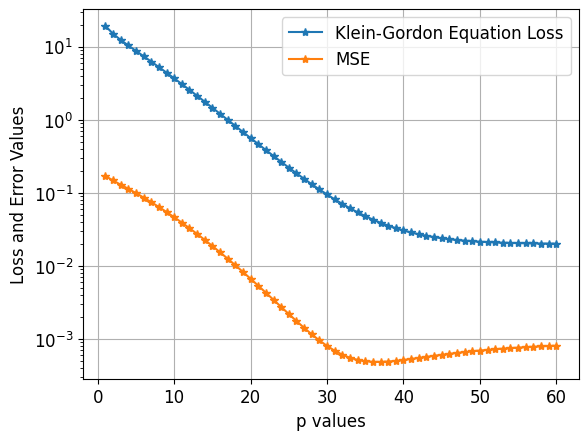

In [206]:
plt.plot(range(1, 61), KG_p[:60], '*-', label='Klein-Gordon Equation Loss');
plt.plot(range(1, 61), mse_p[:60], '*-', label='MSE');
plt.yscale("log");
plt.grid();

plt.legend(fontsize=12);
plt.xlabel('p values', fontsize=12);
plt.ylabel('Loss and Error Values', fontsize=12);
plt.xticks(fontsize=12);
plt.yticks(fontsize=12);

plt.savefig('KG_p_compare.png',dpi=500, bbox_inches='tight')

In [209]:
A_list = [-0.5, 0.5]; k1 = 2
K2_list = np.linspace(1, 2, 50)
landa = 0.8; b = 3; p = 35

manufactured_list = []
perturbation_list = []
KG_loss_list = []
mse_list = []

s = time.time()
for A in A_list:
    for k2 in K2_list:
        ##compute the Perturbation solutions
        force = forcing_decorator4(A, k1, k2, landa, b=b)
        f0_values = force(x, t).detach().numpy()
        result = KG_solver(H_dict, Minv, f0_values, b, landa, H, p=p)
e = time.time()
print((e-s)/100)

Function finisheds in 0.263204 seconds. On average, each PDE is solved using 0.007311 seconds
Function finisheds in 0.282293 seconds. On average, each PDE is solved using 0.007841 seconds
Function finisheds in 0.208517 seconds. On average, each PDE is solved using 0.005792 seconds
Function finisheds in 0.235206 seconds. On average, each PDE is solved using 0.006534 seconds
Function finisheds in 0.186925 seconds. On average, each PDE is solved using 0.005192 seconds
Function finisheds in 0.279387 seconds. On average, each PDE is solved using 0.007761 seconds
Function finisheds in 0.269421 seconds. On average, each PDE is solved using 0.007484 seconds
Function finisheds in 0.26446 seconds. On average, each PDE is solved using 0.007346 seconds
Function finisheds in 0.357868 seconds. On average, each PDE is solved using 0.009941 seconds
Function finisheds in 0.339372 seconds. On average, each PDE is solved using 0.009427 seconds
Function finisheds in 0.390747 seconds. On average, each PDE 

### Better Visualization for the KG results

In [73]:
difference = TL_solution - truth_solution
increasing_performance = (difference**2).mean(axis=1).mean(axis=1).argsort()[::-1]
increasing_performance

array([0, 2, 6, 1, 4, 5, 7, 3])

In [74]:
print("Min difference: ", difference.min())
print("Max Difference: ", difference.max())

Min difference:  -0.07277342088594718
Max Difference:  0.1281157746225654


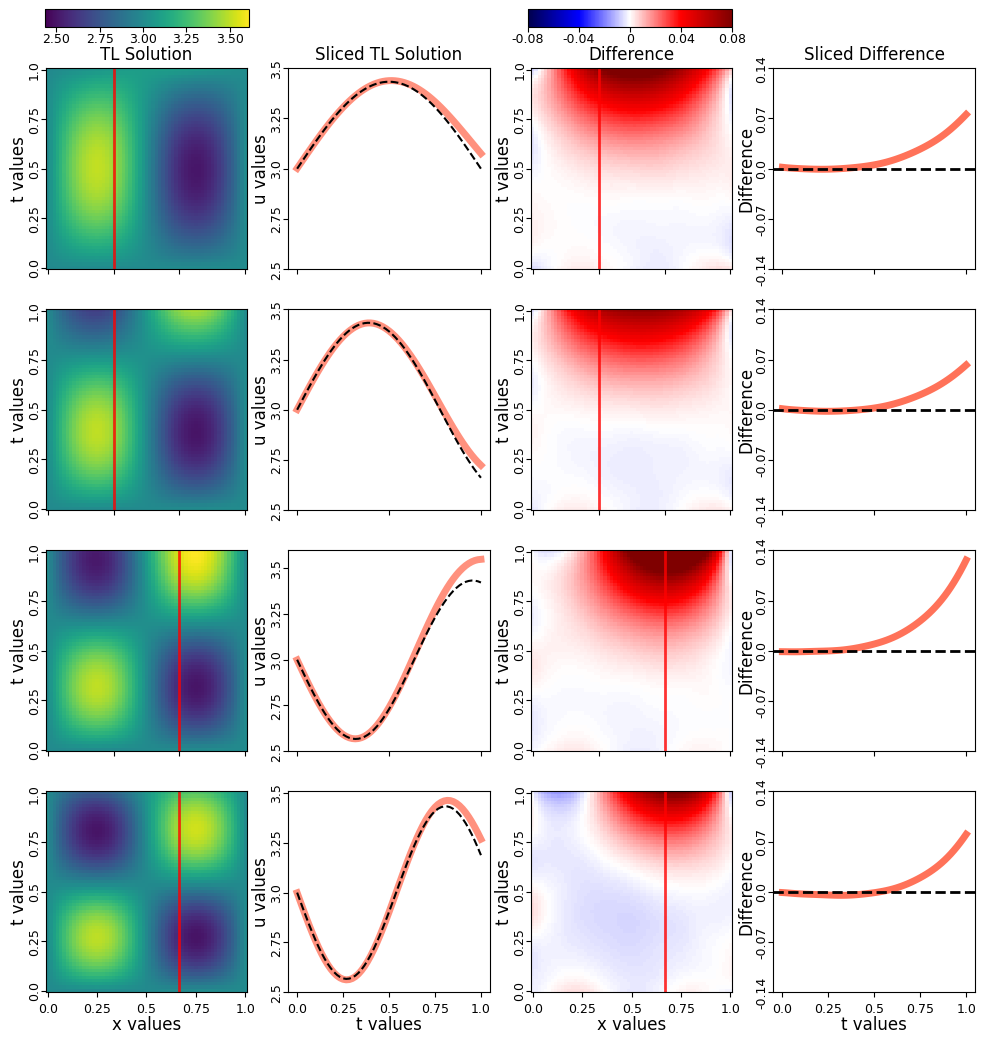

In [97]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12), 
        gridspec_kw={'width_ratios': [1, 1, 1, 1], 'height_ratios': [1, 1, 1, 1]});
sample_indices = [20, 20, 40, 40]
reorder = [4, 5, 6, 7]

# Create color map
cmap1 = plt.get_cmap('viridis');  # You can choose any colormap you prefer
# Create colorbar
global_min = min([result.min() for result in TL_solution])
global_max = max([result.max() for result in TL_solution])
normalizer1 = Normalize(global_min, global_max)
im1 = cm.ScalarMappable(norm=normalizer1, cmap=cmap1)

cmap2 = plt.get_cmap('seismic');  
normalizer2 = Normalize(-0.08, 0.08)
im2 = cm.ScalarMappable(norm=normalizer2, cmap=cmap2)

label_fontsize = 12

for i, sol in enumerate(TL_solution[reorder, :, :]):
    #plot the TL solutions and the differences
    ax[i][0].imshow(sol[::-1, :], cmap=cmap1, norm=normalizer1) # plot the TL solution 
    ax[i][2].imshow(difference[reorder, :, :][i][::-1, :], cmap=cmap2, norm=normalizer2) # plot the difference

    #plot the vertical sample slice line
    ax[i][0].axvline(sample_indices[i], c='red', alpha=.8, lw=2)
    ax[i][2].axvline(sample_indices[i], c='red', alpha=.8, lw=2)

    #plot the sliced function values
    y_values = np.linspace(0, 1, 61)
    ax[i][1].plot(y_values, sol[:,sample_indices[i]], c='tomato', lw=5, alpha=.7)
    ax[i][1].plot(y_values, truth_solution[reorder, :, :][i][:,sample_indices[i]], '--', c='black', lw=1.5)

    #plot the sliced differences
    ax[i][3].plot(y_values, difference[reorder, :, :][i][:,sample_indices[i]], c='tomato', lw=5, alpha=.9)
    ax[i][3].axhline(0, ls='--', c='black', lw=2)
    ax[i][3].set_ylim(-0.01, 0.01)

    if i == 3:
        ax[i][0].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][0].set_xlabel("x values", fontsize=label_fontsize, labelpad=0);

        ax[i][1].set_xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][1].set_xlabel("t values", fontsize=label_fontsize, labelpad=0);

        ax[i][2].set_xticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][2].set_xlabel("x values", fontsize=label_fontsize, labelpad=0);

        ax[i][3].set_xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize=9);
        ax[i][3].set_xlabel("t values", fontsize=label_fontsize, labelpad=0);
    else:
        for j in range(4):
            ax[i][j].set_xticklabels([]);
            ax[i][j].set_xlabel('');

    ax[i][0].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=9);
    ax[i][2].set_yticks(np.linspace(0, 60, 5), np.linspace(0, 1, 5)[::-1], fontsize=9);
    ax[i][0].set_ylabel('t values', fontsize=label_fontsize, labelpad=0);
    ax[i][2].set_ylabel('t values', fontsize=label_fontsize, labelpad=0);
    ax[i][1].set_yticks([round(val, 2) for val in np.linspace(2.5, 3.5, 5)], 
                        [round(val, 2) for val in np.linspace(2.5, 3.5, 5)], fontsize=9);
    ax[i][3].set_yticks(np.linspace(-0.14, 0.14, 5), np.linspace(-0.14, 0.14, 5), fontsize=9);
    ax[i][1].set_ylabel('u values', fontsize=label_fontsize, labelpad=0);
    ax[i][3].set_ylabel('Difference', fontsize=label_fontsize, labelpad=0);
    
    for j in range(4):
        ax[i][j].tick_params(axis='y', labelrotation=90, pad=.1)
        for label in ax[i][j].get_yticklabels():
            label.set_verticalalignment('center')

    
    
# Create a color bar axis
cax1 = fig.add_axes([0.125, 0.914, 0.17, 0.015])  # [left, bottom, width, height]
cbar1 = fig.colorbar(im1, ax=ax.ravel().tolist(), cax=cax1, orientation='horizontal')
cbar1.ax.tick_params(labelsize=9); cbar1.ax.tick_params(pad=0)

cax2 = fig.add_axes([0.527, 0.914, 0.17, 0.015])  # [left, bottom, width, height]
cbar2 = fig.colorbar(im2, ax=ax.ravel().tolist(), cax=cax2, orientation='horizontal')
cbar2.ax.tick_params(labelsize=9); cbar2.ax.tick_params(pad=0)
cbar2.set_ticks(np.linspace(-0.08, 0.08, 5))  # Set the ticks positions
cbar2.set_ticklabels(['-0.08', '-0.04', '0', '0.04', '0.08'])  # Set the custom tick labels

ax[0][0].set_title("TL Solution");
ax[0][1].set_title("Sliced TL Solution");
ax[0][2].set_title("Difference");
ax[0][3].set_title("Sliced Difference");

plt.savefig('KG_result2.png',dpi=500, bbox_inches='tight')

In [82]:
print(difference[reorder, :, :].min())
print(difference[reorder, :, :].max())

-0.015788608133952664
0.1281157746225654
